In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Generating a 2 by 100 array of all peg locations

pegLocations=np.zeros([2,100])
for i in range(0,10):
    for j in range(0,10):
    #Saving x-locations of all pegs
        if i%2==0:
            pegLocations[0,j+i*10]=10*j
        if i%2!=0:
            pegLocations[0,j+i*10]=10*j+5
    #Saving all y-locations of pegs        
    pegLocations[1,(i*10):(i+1)*10]=86.66-(8.66*(i+1))

In [4]:
#Defining gravitational constant
g=981 #cm/s

#Defining x and y acceleration expressions
#Note that if statements are used to account for direction of drag

def ax(Vx,C):
    if Vx<=0:
        ans=C*Vx**2
    else:
        ans = -C*Vx**2
    return ans


def ay(Vy,C):
    if Vy<=0:
        ans=-g+C*(Vy)**2
    else:
        ans=-g-C*(Vy)**2
    return ans

In [5]:
h=0.001 #initializing time step used throughout code

#Defining velocity function using forward Euler's method
def Vel(V0x,V0y,C):
    vx=V0x+h*ax(V0x,C)
    vy=V0y+h*ay(V0y,C)
    return vx,vy

In [6]:
#defining a function to model the position of the ball using forward Euler's method

def Pos(x0,Vx,y0,Vy,h):
    x=x0+h*Vx
    y=y0+h*Vy
    return x,y

In [7]:
#Defining a simple function to model bouncing off pegs. This function outputs velocities vx and vy

def bounce(x,y,pegx,pegy,vx,vy):
    xdist=x-pegx
    ydist=y-pegy
    #Accounting for case where disk hits peg straight on causing the velocity in y direction to 'flip'
    if xdist==0:
        return vx,-vy
    
    #Accounting for the case where the disk hits the peg at an angle
    else:
        theta=np.arctan(ydist/xdist)
        
        #introducing randomness of up to 10% to angle that disk bounces off the peg
        highThresh=theta+(theta*0.1)
        lowThresh=theta-(theta*0.1)
        thetaRand=float(np.random.uniform(lowThresh,highThresh))
        
        #Applying vector reflection matrix
        reflMat=np.array(([np.cos(2*thetaRand),np.sin(2*thetaRand)],[np.sin(thetaRand*2),-np.cos(2*thetaRand)]))
        velMat=np.array(([vx],[vy]))
        VxRef,VyRef=-np.matmul(reflMat,velMat)[0],-np.matmul(reflMat,velMat)[1]
        
        #Introducing random reduction of velocity of up to 5% upon hitting peg
        VxRef2=float(np.random.uniform(VxRef-(VxRef*0.05),VxRef))
        VyRef2=float(np.random.uniform(VyRef-(VyRef*0.05),VyRef))
        
    return VxRef2,VyRef2

In [13]:
#Applying simp 1/3 method of integration 

def integrate(y, h):
    
    
    ind = 1
    tot = y[0] + y[-1]
    
    for i in y[1:-1]:
        if (ind % 2) == 0:
            tot += 2 * i
            
            
        else:
            tot += 4 * i
        ind += 1
    return tot * (h / 3.0)


In [14]:
def Plinko(xstart,drag,totaltime):
    #Setting initial conditions
    t=0
    N=int(totaltime*1000)
    C=drag
    y0= np.random.uniform(89.8,90.2)
    x0=np.random.uniform(xstart-0.2,xstart+0.2)
    prevVx=np.random.uniform(0,0.2)
    prevVy=np.random.uniform(0,0.2)
    
    #Plotting the pegs in blue
    plt.plot(pegLocations[0],pegLocations[1],'.')
    
    #Initializing position and velocity arrays so that values can be plotted
    xArray=np.zeros(N)
    yArray=np.zeros(N)
    vxArray=np.zeros(N)
    vyArray=np.zeros(N)
    
    #The dummy variable below is simply used to ensure bounce function is not triggered in consecutive time iterations as that causes the ball to move in physically impossible ways.
    dumVar=0
    
    #Initializing variables used to calculate total distance travelled by the disk
    dist=0
    totaldist=0
    
    
    #Looping through all possible time values
    for i in range(0,N):
        velx,vely=Vel(prevVx,prevVy,C)
        x1,y1=Pos(x0,velx,y0,vely,h)
        dist=float(np.sqrt((x1-x0)**2+(y1-y0)**2))  #Change in position of the disk
        totaldist=dist+totaldist
        x0=np.copy(x1)
        y0=np.copy(y1)
    
    #Converting these values from 1x1 arrays to floats so functions work properly
        x0f=float(x0)
        y0f=float(y0)
        velxf=float(velx)
        velyf=float(vely)
        
        #If statements are used to ensure that disk will go to opposite end of board if x=0 or x=100
        if x0f > 100:
            x0f = x0f-100
        if x0f< 0:
            x0f = x0f+100
    
    #Plotting position of disk in red
        plt.plot(x0f,y0f,'ro')
    
    #storing position and velocity values in an array so they can be plotted later
        xArray[i]=x0f
        yArray[i]=y0f
        vxArray[i]=velxf
        vyArray[i]=velyf
    
#Stops iterating through time if disk reaches bottom of board
        if y0f<=0:
            t=0.001*i
            numIterations=i
            #determining which bin the disk landed in
            if x0f<=5.0 or x0f>95.0:
                Bin=int(0)
            else:
                Bin=(x0f+5)//10
            
            break
        
#Looping through pegLocations array to determine if disk is bouncing off of a peg or falling at any given moment

        for j in range(0,np.size(pegLocations[0,:])):
            if (np.sqrt(((x0f-pegLocations[0,j])**2)+(y0f-pegLocations[1,j])**2)<=3.0) and dumVar==0:  
                
#If above conditions are met, bounce function will be applied. The 3.0cm threshold is based off the sum of the radius of the peg and the disk (2.5cm+0.5cm).
                
                
                posPegx=pegLocations[0,j]
                posPegy=pegLocations[1,j]
                newVel=bounce(x0f,y0f,posPegx,posPegy,velxf,velyf)
            
                prevVx=np.copy(newVel[0])
                prevVy=np.copy(newVel[1])
            
                dumVar=1
               
                
                break
            
            #If rebounding function is not called, ball will just move according to velocity function
            else:
                prevVx=np.copy(velx)
                prevVy=np.copy(vely)
            
            #If the for loop reaches the end of the pegLocations array without triggering the bounce function, the disk experiences 'falling motion'. We set dumVar to 0 in this case because it is now physically possible for the disk to fall and hit another peg so the bounce function can be called.
            if j==(np.size(pegLocations[0,:]))-1:
                dumVar=0
                
                
    #Truncating x,y,vx, and vy arrays and initializing time array
    xArrayt=xArray[0:numIterations]
    yArrayt=yArray[0:numIterations]
    vxArrayt=vxArray[0:numIterations]
    vyArrayt=vyArray[0:numIterations]
    timeArray=np.zeros(numIterations)
    for i in range(0,numIterations):
        timeArray[i]=i*0.001
    
    #Using fft to calculate the maximally occurring frequency
    freq = np.fft.fft(vyArrayt[1:])
    maxfreqoccur = np.argmax(freq[1:150])
    freqarea = abs(integrate(freq[1:200],1))
    

    #Plotting position vs t, velocity vs t, and frequency
    plt.figure(2)
    plt.plot(timeArray,xArrayt,'-',label="x(t)")
    plt.plot(timeArray,yArrayt,'-',label="y(t)")
    plt.xlabel("time [s]")
    plt.ylabel("position [m]")
    plt.legend()

    plt.figure(3)
    plt.plot(timeArray,vxArrayt,'-',label="vx(t)")
    plt.plot(timeArray,vyArrayt,'-',label="vy(t)")
    plt.xlabel("time [s]")
    plt.ylabel("velocity [m/s]")
    plt.legend()
    
    plt.figure(4)
    plt.plot(abs(freq[1:150]))
    plt.xlabel("Frequency of change of direction [Hz]")
    plt.ylabel("Number of Occurences")
    

                    
    return t,Bin,totaldist,maxfreqoccur,freqarea

In [12]:
#Copying above plinko function but removing all plotting parts as they're unnecessary for histogram generation

def PlinkoHist(xstart,drag,totaltime):
    #Setting initial conditions
    numIterations=0  
    Bin=0
    t=0
    N=int(totaltime*1000)
    C=drag
    y0= np.random.uniform(89.8,90.2)
    x0=np.random.uniform(xstart-0.2,xstart+0.2)
    prevVx=np.random.uniform(0,0.2)
    prevVy=np.random.uniform(0,0.2)
    
    
    #Initializing position and velocity arrays so that values        can be plotted
    xArray=np.zeros(N)
    yArray=np.zeros(N)
    vxArray=np.zeros(N)
    vyArray=np.zeros(N)
    
    
    
    #The dummy variable below is simply used to ensure bounce function is not triggered in consecutive time iterations as that caused the ball to move in physically impossible ways.
    dumVar=0
    dist=0
    totaldist=0
    
    
    #Looping through all possible time values
    for i in range(0,N):
        velx,vely=Vel(prevVx,prevVy,C)
        x1,y1=Pos(x0,velx,y0,vely,h)
        dist=float(np.sqrt(abs(x1**2-x0**2)+abs(y1**2-y0**2)))
        totaldist=dist+totaldist
        x0=np.copy(x1)
        y0=np.copy(y1)
    
    #Converting these values from 1x1 arrays to floats so functions work properly
        x0f=float(x0)
        y0f=float(y0)
        velxf=float(velx)
        velyf=float(vely)
        vyArray[i]=velyf
        
        #If statements are used to ensure that disk will go to opposite end of board if x=0 or x=100
        if x0f > 100:
            x0f = x0f-100
        if x0f< 0:
            x0f = x0f+100

    
#Stops iterating through time if disk reaches bottom of board
        if y0f<=0:
            t=0.001*i
            numIterations=i
            #determining which bin the disk landed in
            if x0f<=5.0 or x0f>95.0:
                Bin=int(0)
            else:
                Bin=(x0f+5)//10
            
            break
        
#Looping through pegLocations array to determine if disk is bouncing off of a peg or falling at any given moment
        for j in range(0,np.size(pegLocations[0,:])):
            if (np.sqrt(((x0f-pegLocations[0,j])**2)+(y0f-pegLocations[1,j])**2)<=3.0) and dumVar==0:  #If these conditions are met, bounce function will be applied. The 3.0cm threshold is based off the sum of the radius of the peg and the disk (2.5cm+0.5cm).
                
                
                posPegx=pegLocations[0,j]
                posPegy=pegLocations[1,j]
                newVel=bounce(x0f,y0f,posPegx,posPegy,velxf,velyf)
            
                prevVx=np.copy(newVel[0])
                prevVy=np.copy(newVel[1])
            
                dumVar=1
               
                
                break
            
            #If rebounding function is not called, ball will just move according to velocity function
            else:
                prevVx=np.copy(velx)
                prevVy=np.copy(vely)
            
            #If the for loop reaches the end of the pegLocations array without triggering the bounce function, the disk experiences 'falling motion'. We set dumVar to 0 in this case because it is now physically possible for the disk to fall and hit another peg so the bounce function can be called.
            if j==(np.size(pegLocations[0,:]))-1:
                dumVar=0
                
    timeArray=np.zeros(numIterations)
    vyArrayt=vyArray[0:numIterations]
    
    for i in range(0,numIterations):
        timeArray[i]=i*0.001
        
    #max frequency and area
    freq = np.fft.fft(vyArrayt[1:])    
    maxfreqoccur = np.argmax(freq[1:150])
    freqarea = abs(integrate(freq,1))
    
    
    return t,Bin,totaldist,maxfreqoccur, freqarea

# For a Total Drag Coefficient of 0.5

It takes  3.753 seconds for the disk to move through the plinko board.
The disk lands in bin 5.0
The total distance travelled by disk is 123.11054192049028 cm
The Area Under the Frequency Curve is 31173.038126919964 s^-2
Maximum Frequency Occurance is at 10 Hz


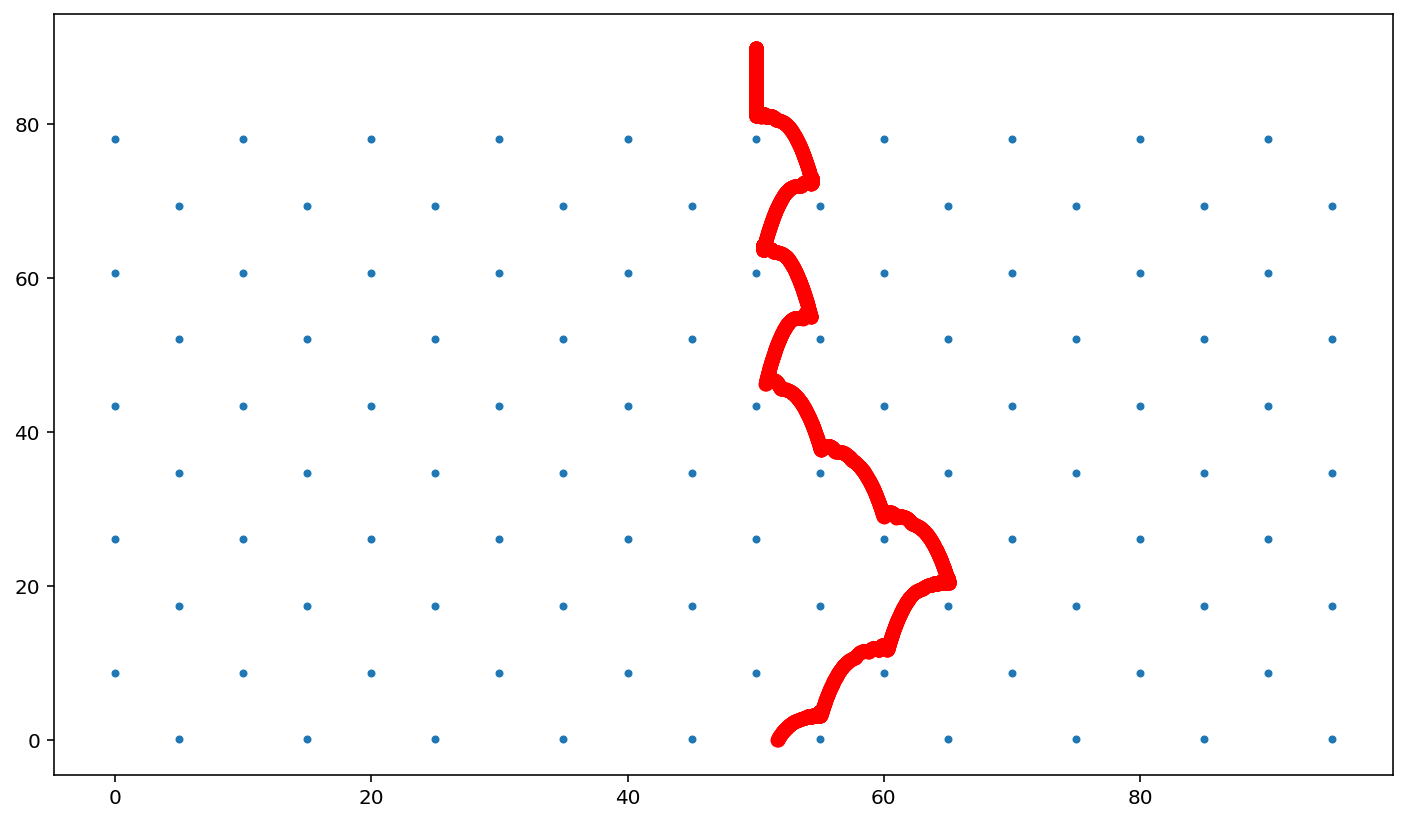

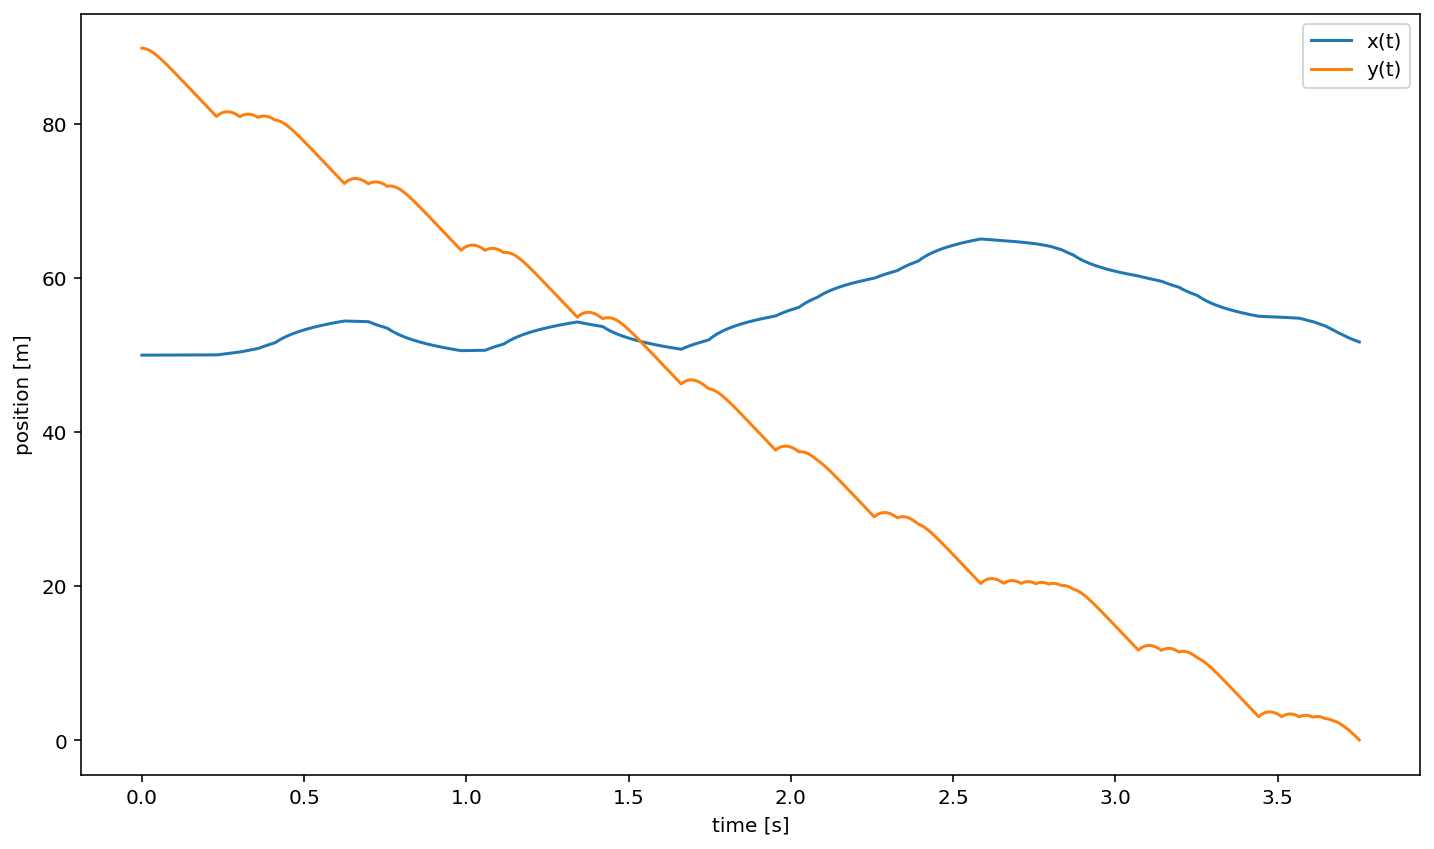

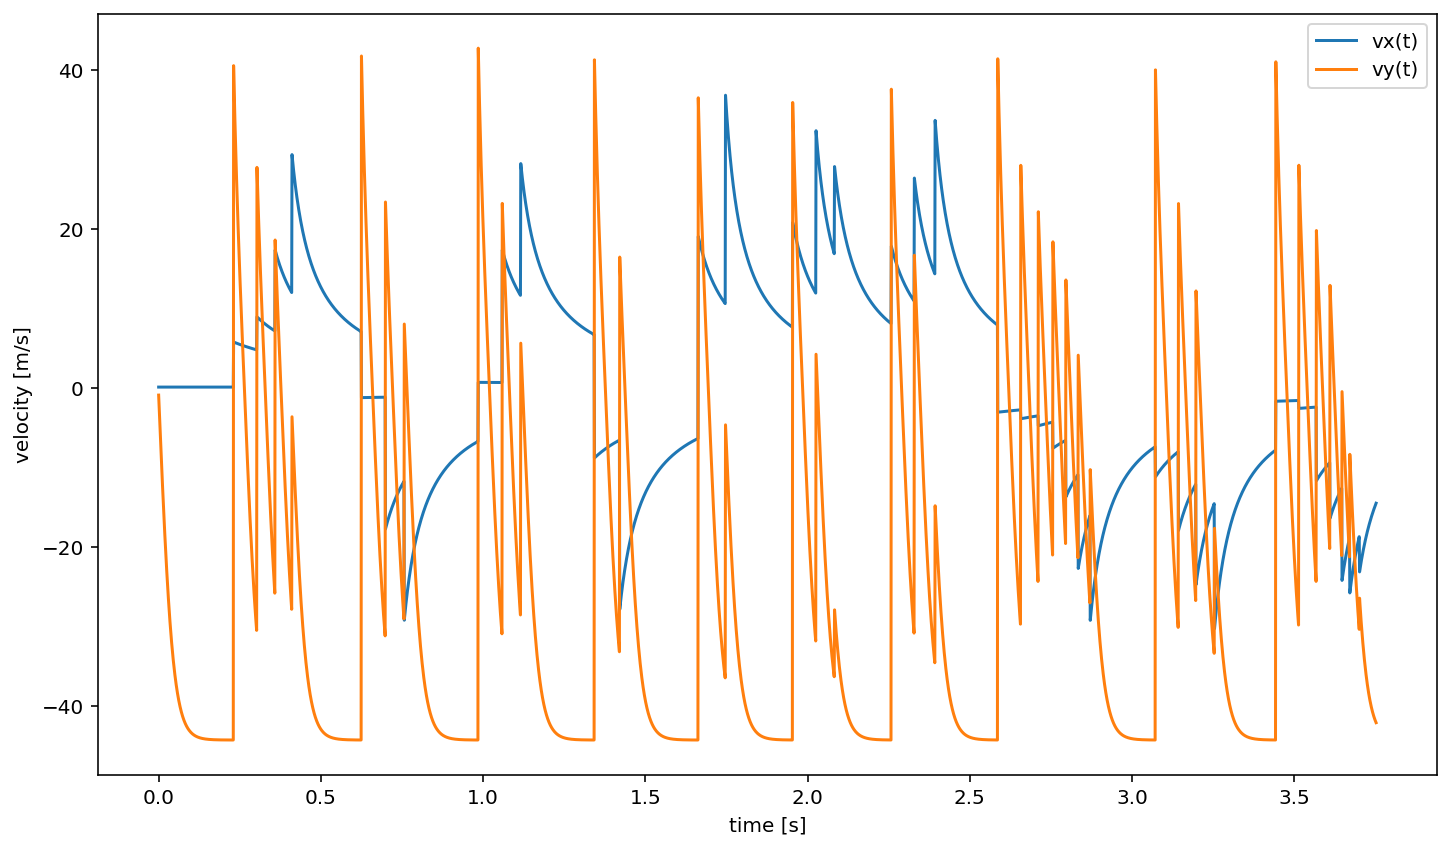

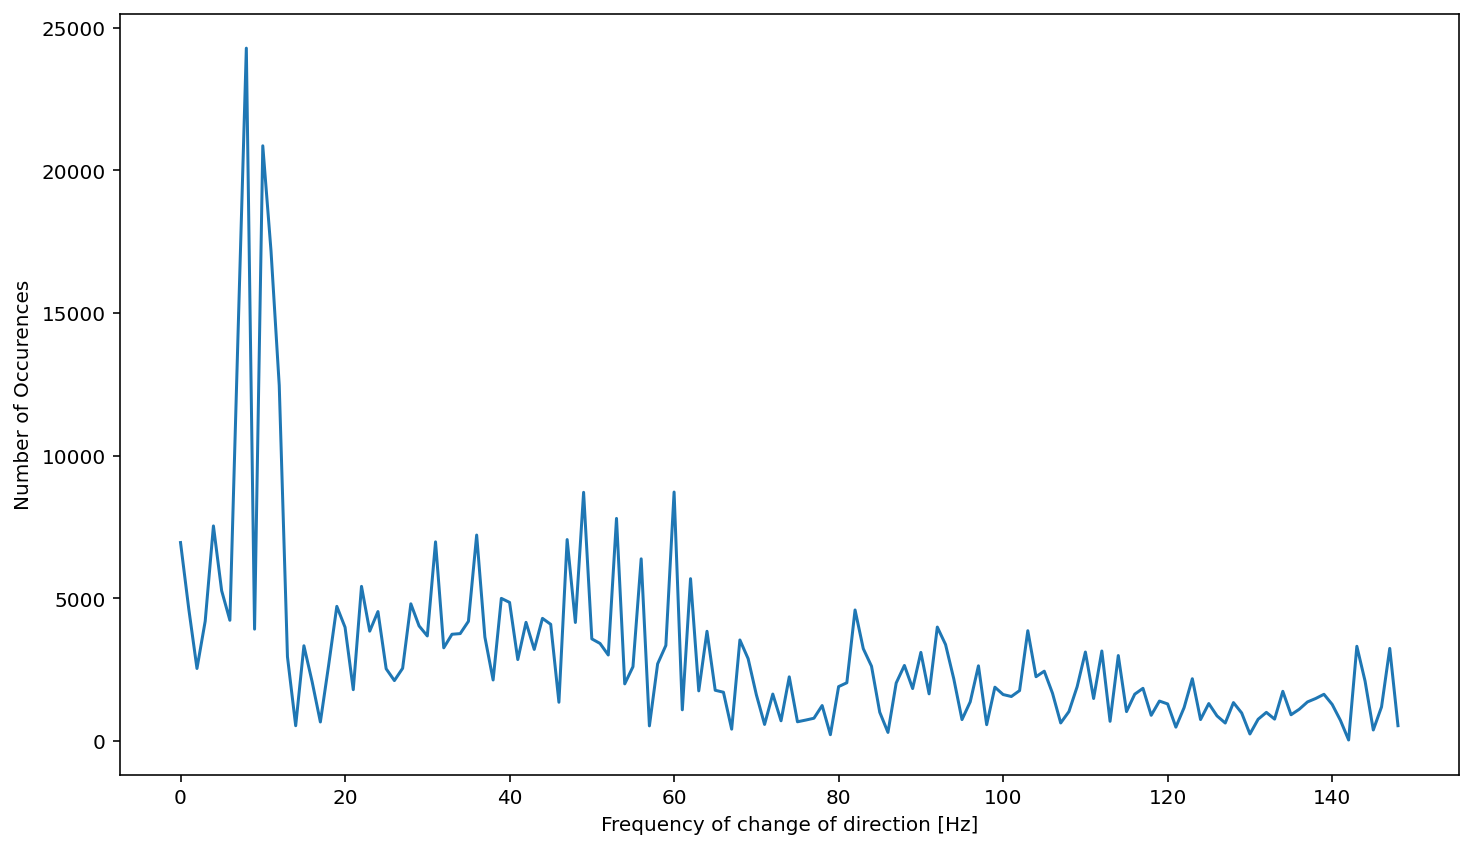

In [15]:
test,Bin,td,maxf,farea=Plinko(50,0.5,5.0)
print("It takes ",test, "seconds for the disk to move through the plinko board.")
print("The disk lands in bin",Bin)
print("The total distance travelled by disk is", td,"cm")
print("The Area Under the Frequency Curve is",farea,"s^-2" )
print("Maximum Frequency Occurance is at",maxf,"Hz")

In [0]:
#generating histograms

#Note that code will take approximately 50 seconds to do 20 'runs' and 80 seconds for 30 runs

#Initializing the number of runs
num=20
tArr=np.zeros(num)
binArr=np.zeros(num)
tdArr=np.zeros(num)
maxfreqArray=np.zeros(num)
freqAreaArray=np.zeros(num)
for i in range(0,num):
    tArr[i],binArr[i],tdArr[i],maxfreqArray[i],freqAreaArray[i]=PlinkoHist(50,0.5,5.0)
    
#plotting histograms for all output values
    
plt.figure(1)
plt.hist(tArr,bins=5)
plt.xlabel("time [s]")
plt.ylabel("frequency of occurence")
           
plt.figure(2)
plt.hist(binArr,bins=10,range=(0,10))
plt.xlabel("Bin Number")
plt.ylabel("frequency of occurence")

plt.figure(3)
plt.hist(tdArr,bins=5)
plt.xlabel("Total displacement [m]")
plt.ylabel("frequency of occurence")

plt.figure(4)
plt.hist(maxfreqArray,bins=5)
plt.xlabel("Maximum Frequency [Hz]")
plt.ylabel("frequency of occurence")

plt.figure(5)
plt.hist(freqAreaArray,bins=5)
plt.xlabel("Integrated Area under all frequencies [s^-2]")
plt.ylabel("frequency of occurence")
           

# For a Total Drag Coefficient of 0.1

It takes  1.744 seconds for the disk to move through the plinko board.
The disk lands in bin 8.0
The total distance travelled by disk is 133.25542101575226 cm
The Area Under the Frequency Curve is 74718.38236147874 s^-2
Maximum Frequency Occurance is at 0 Hz


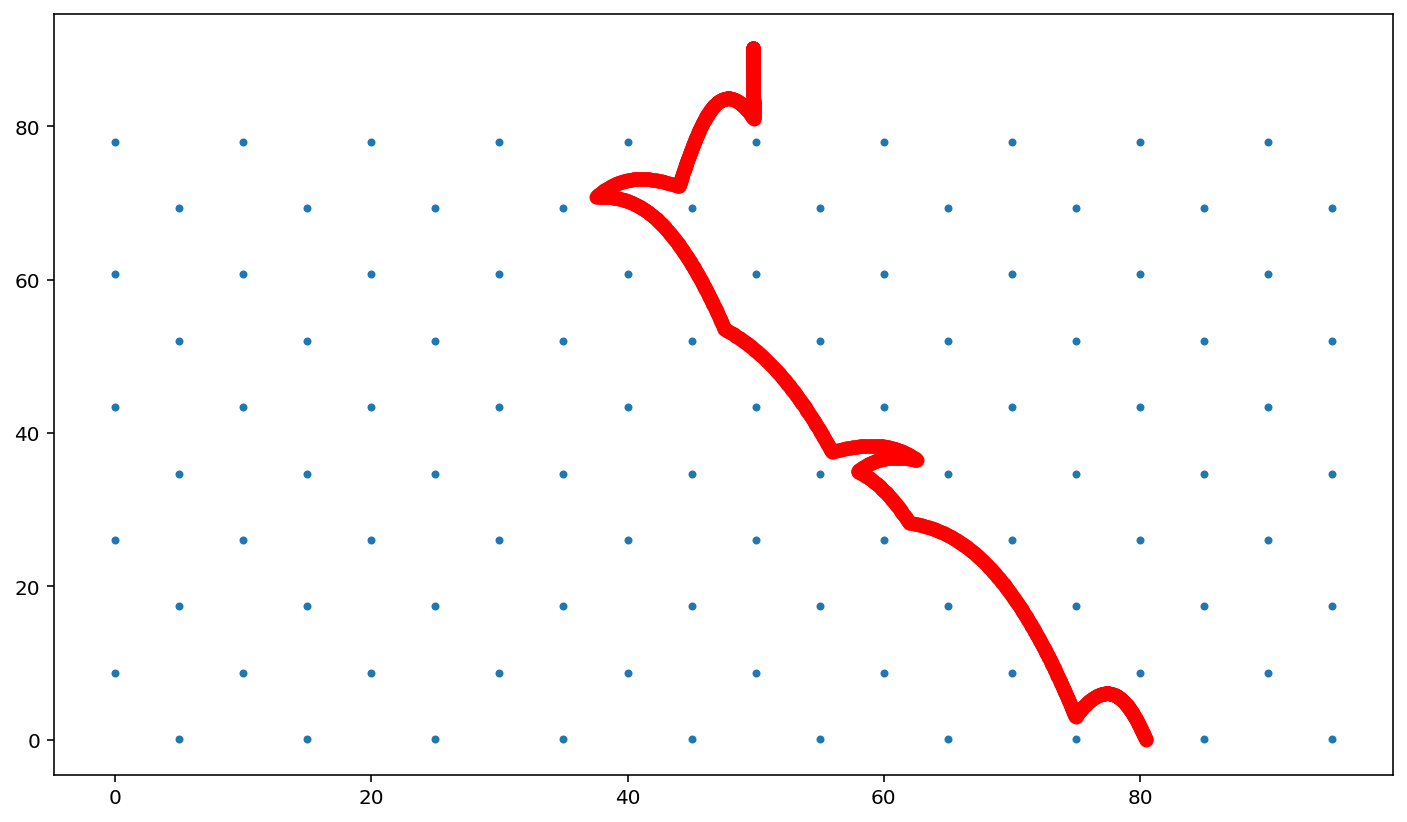

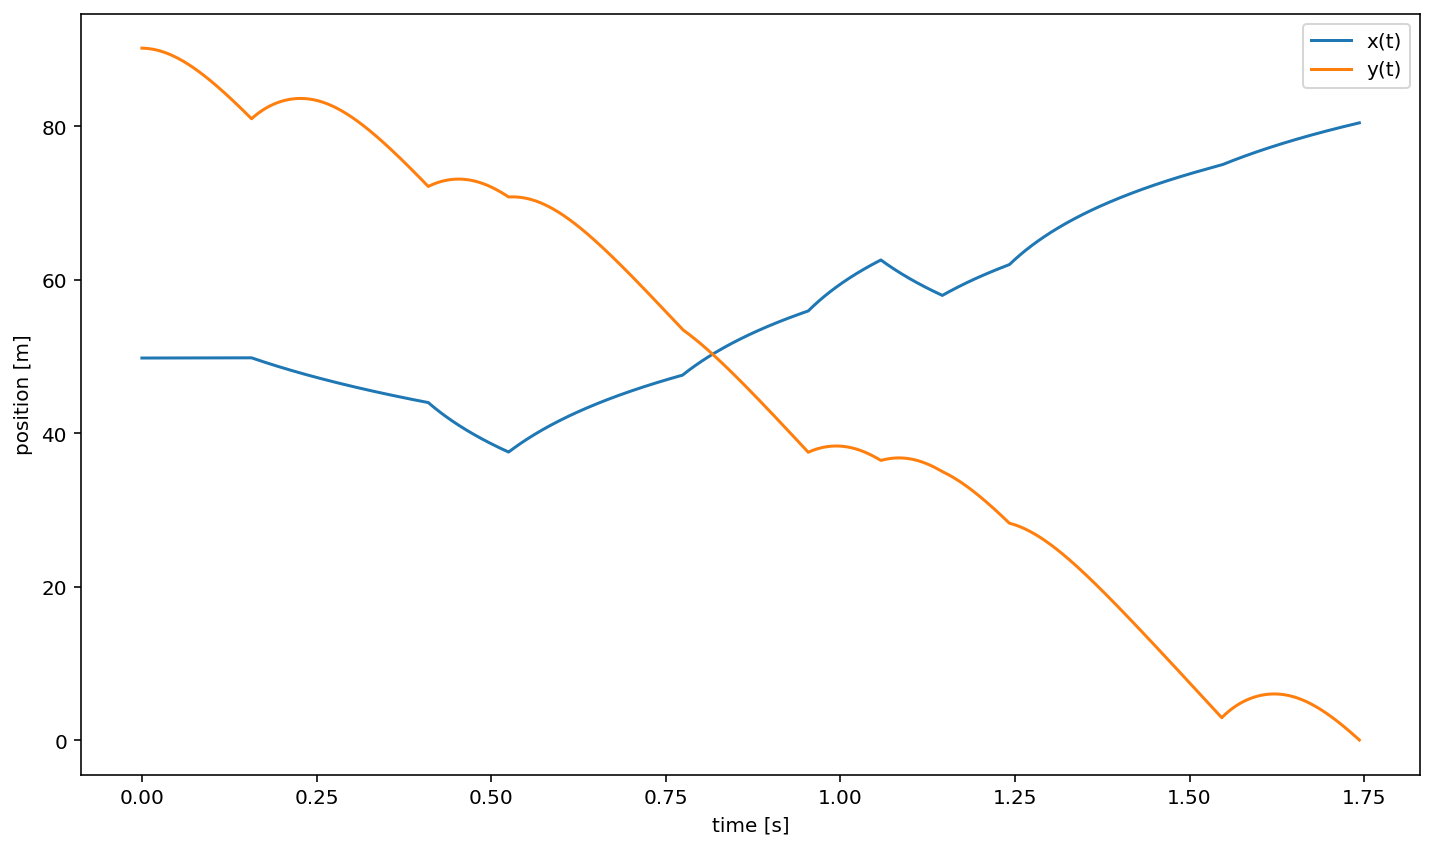

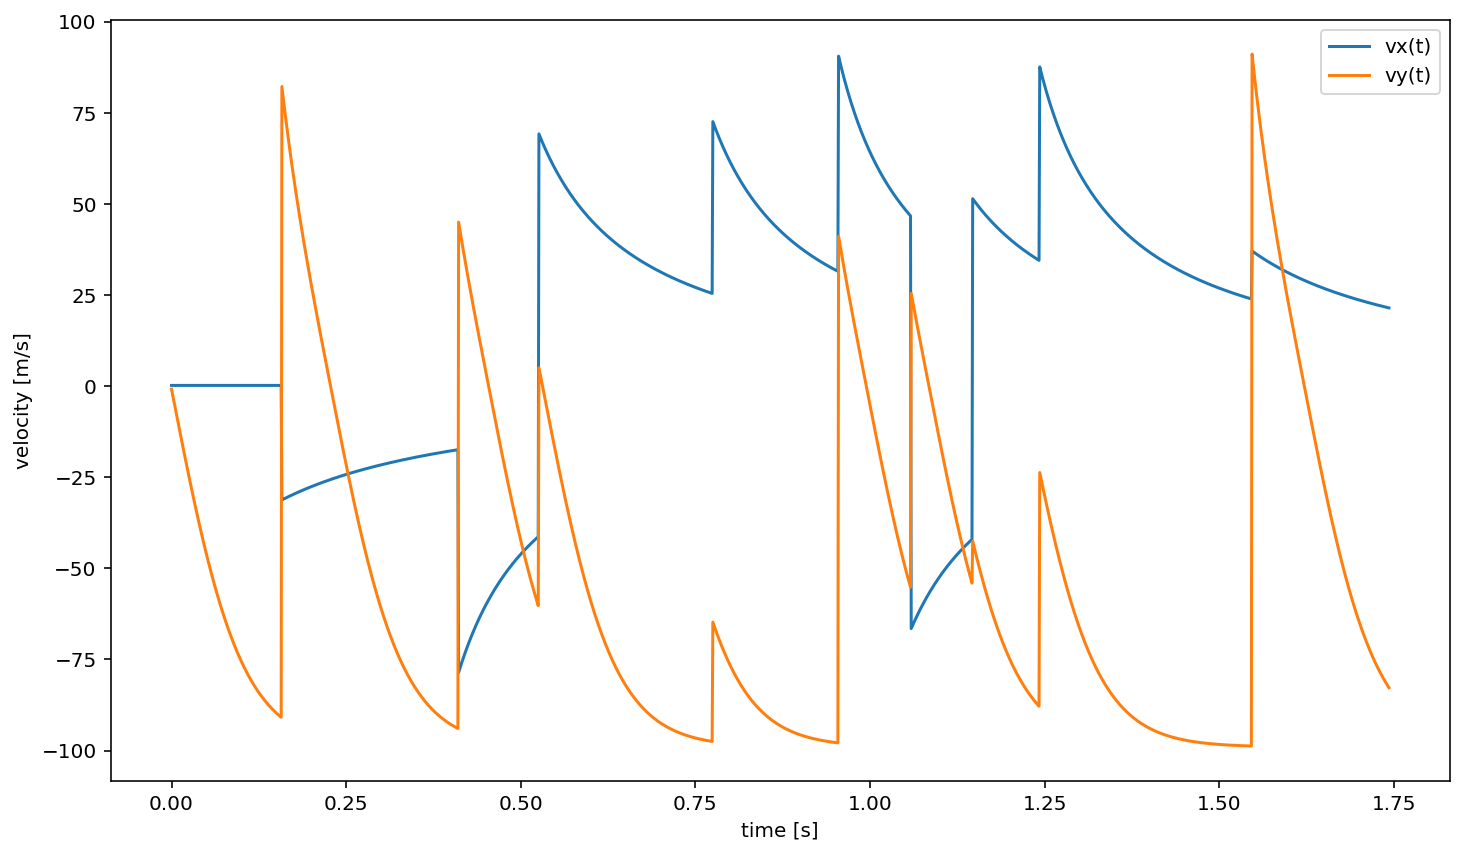

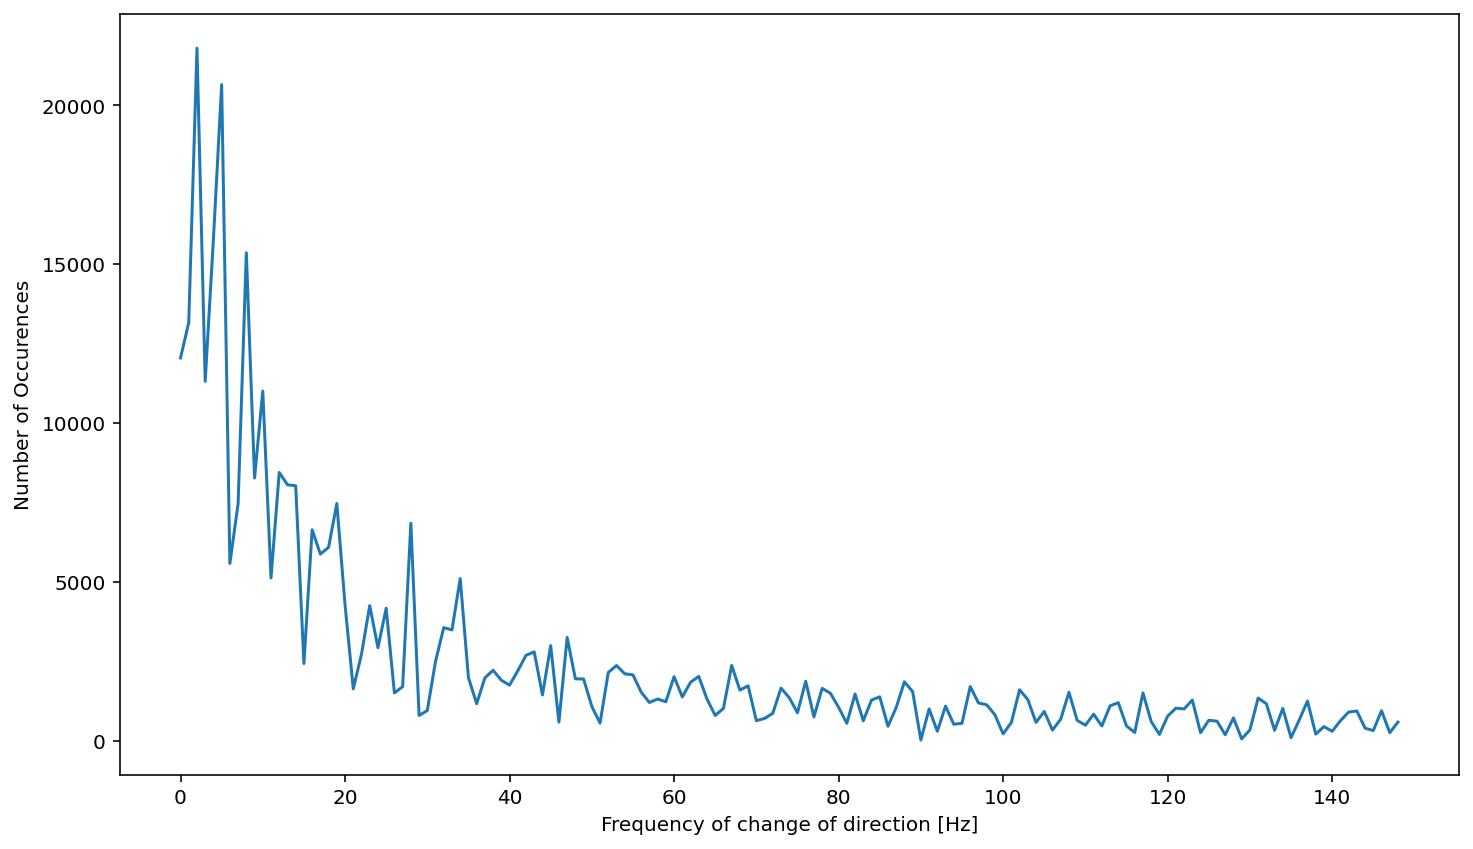

In [12]:
test,Bin,td,maxf,farea=Plinko(50,0.1,5.0)
print("It takes ",test, "seconds for the disk to move through the plinko board.")
print("The disk lands in bin",Bin)
print("The total distance travelled by disk is", td,"cm")
print("The Area Under the Frequency Curve is",farea,"s^-2" )
print("Maximum Frequency Occurance is at",maxf,"Hz")

Text(0, 0.5, 'frequency of occurence')

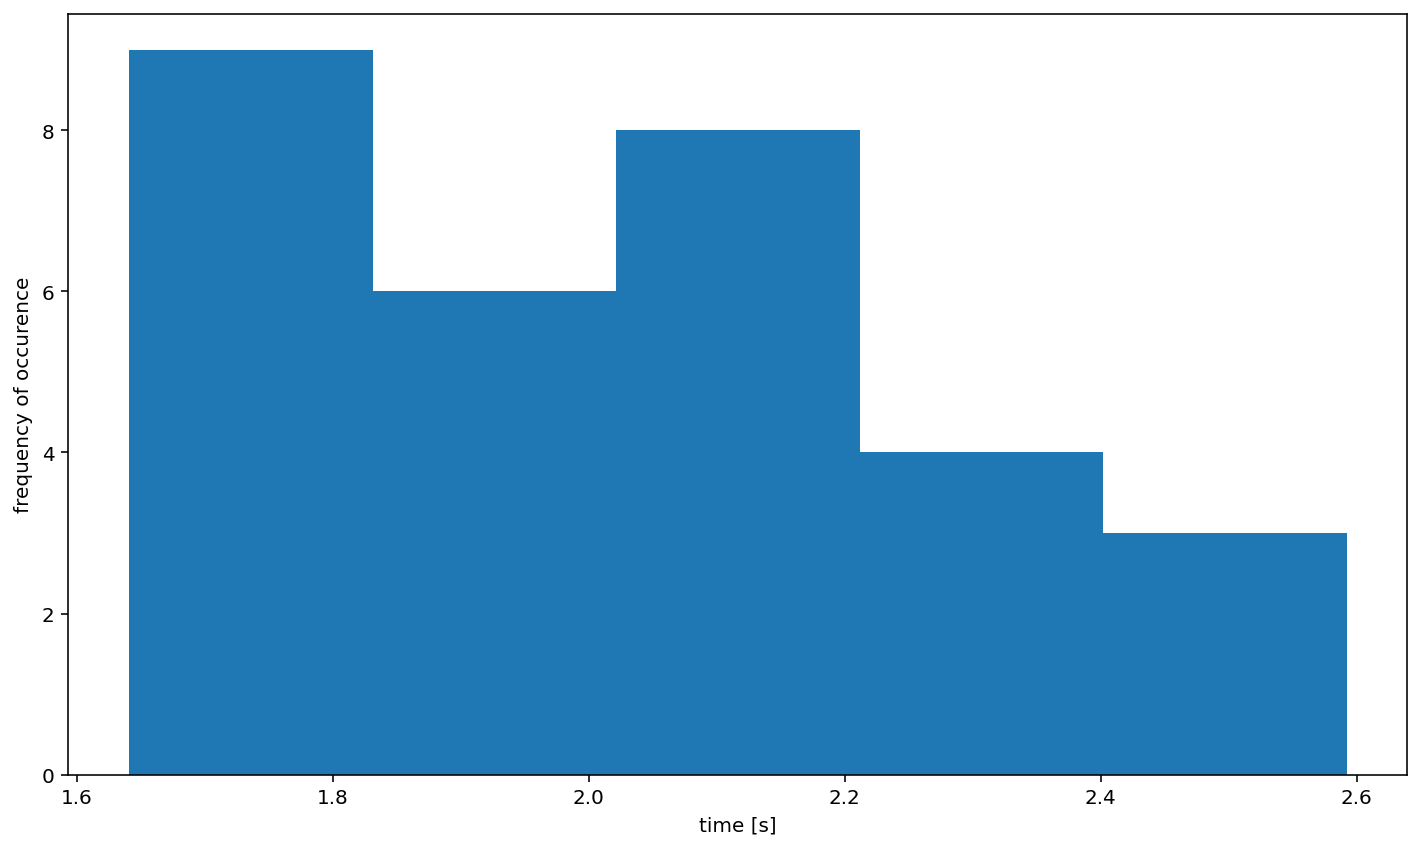

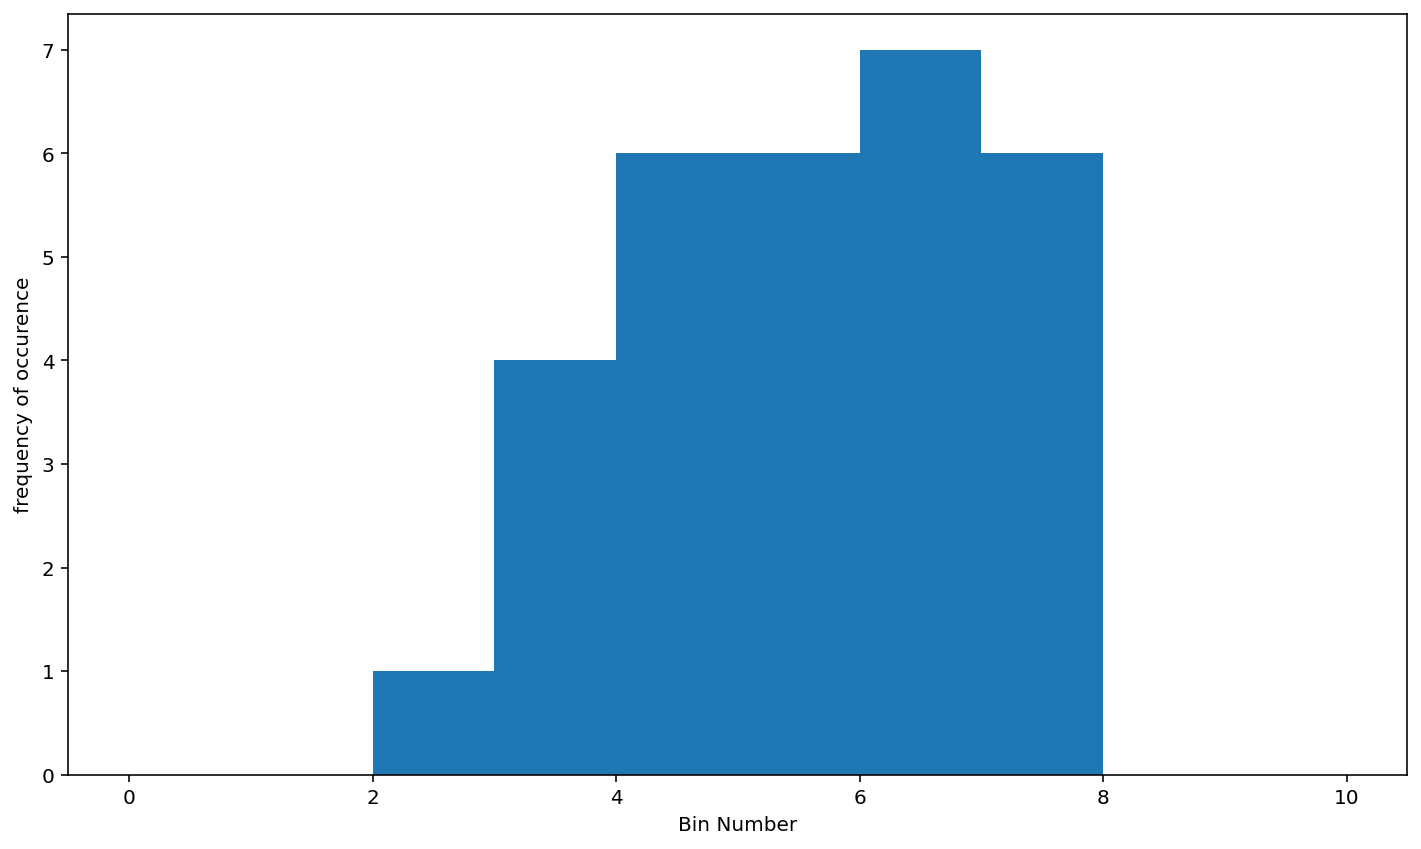

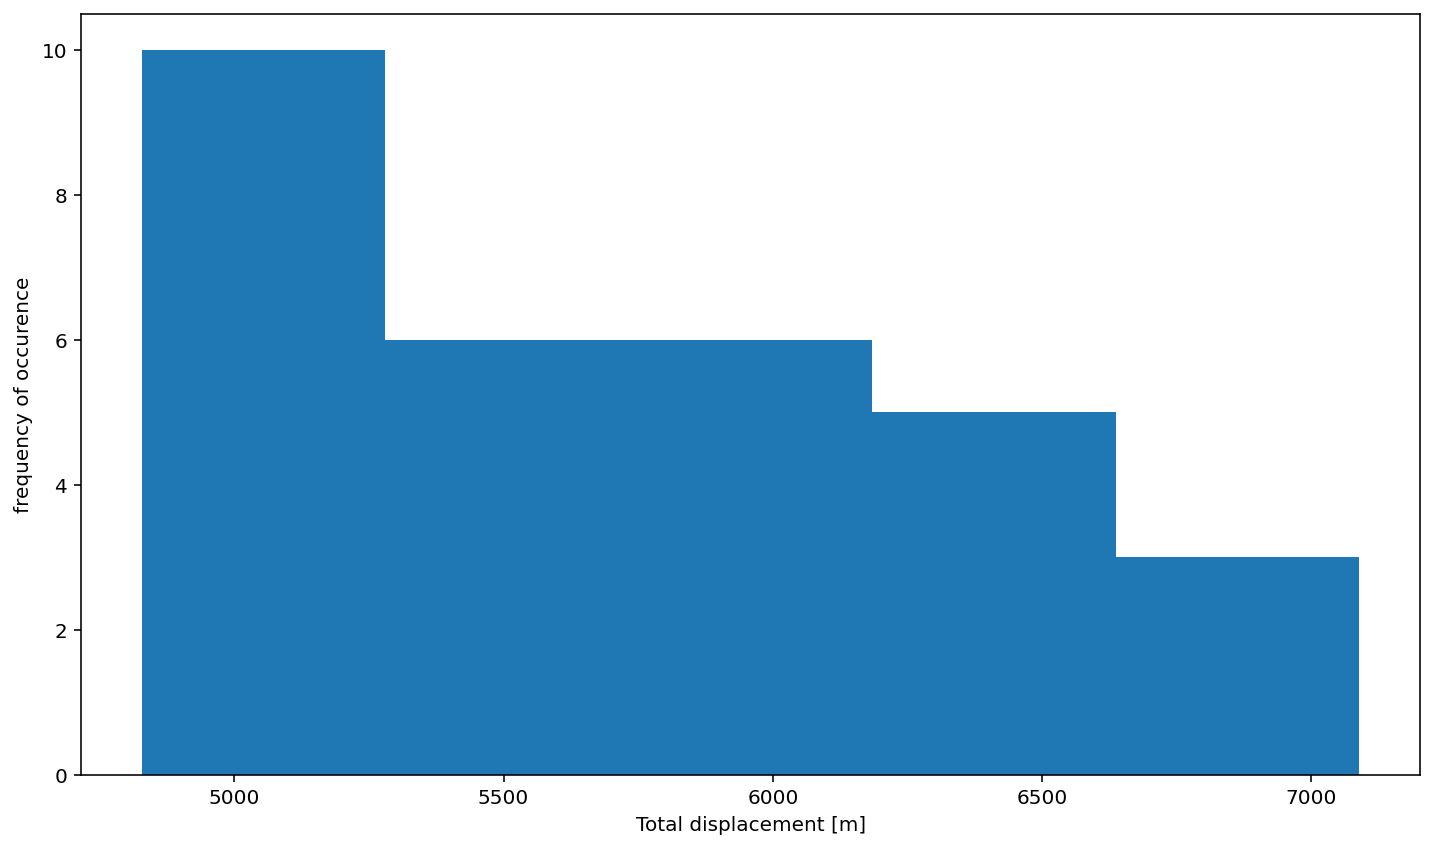

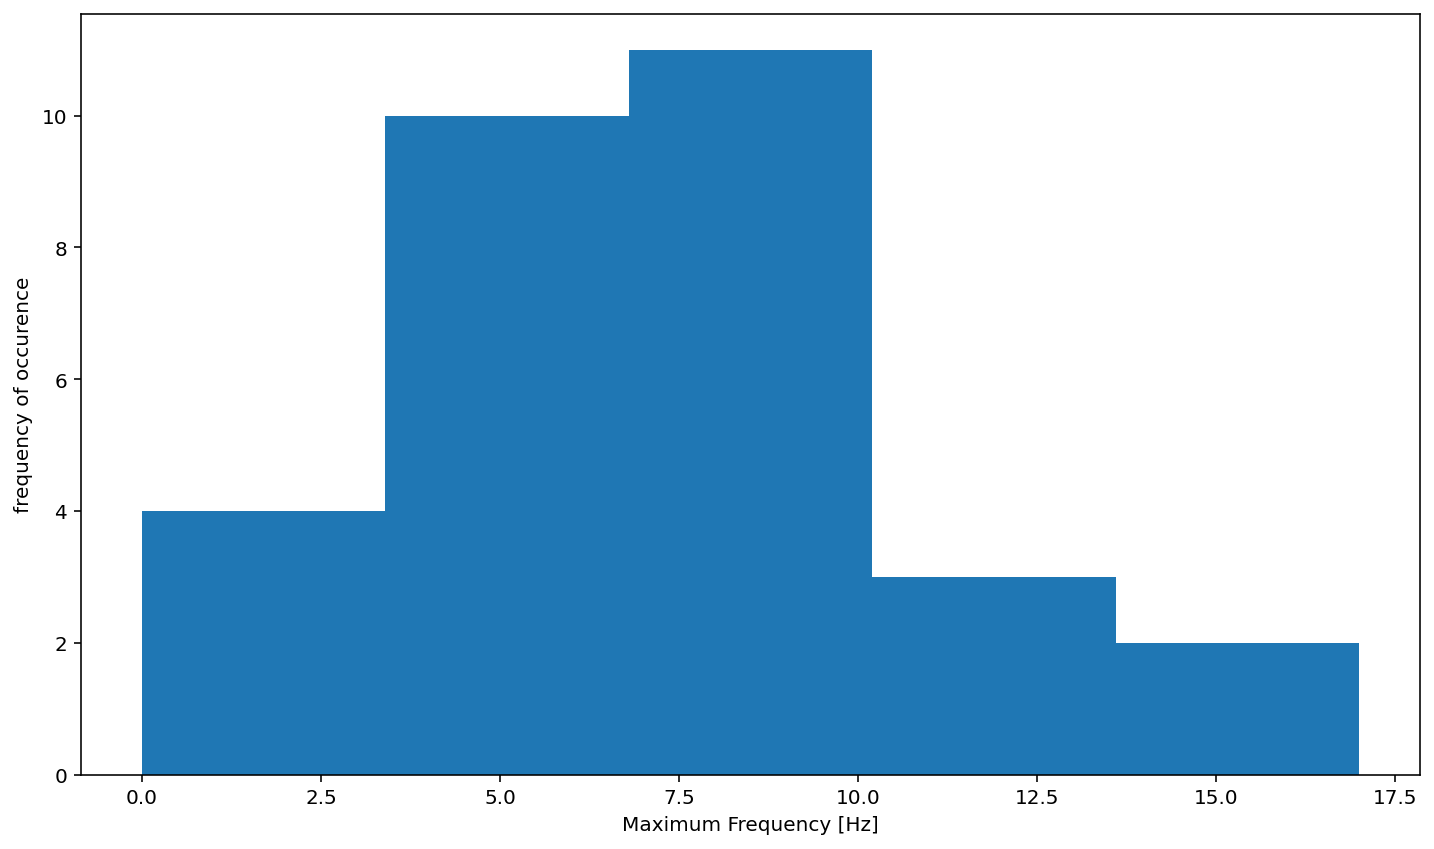

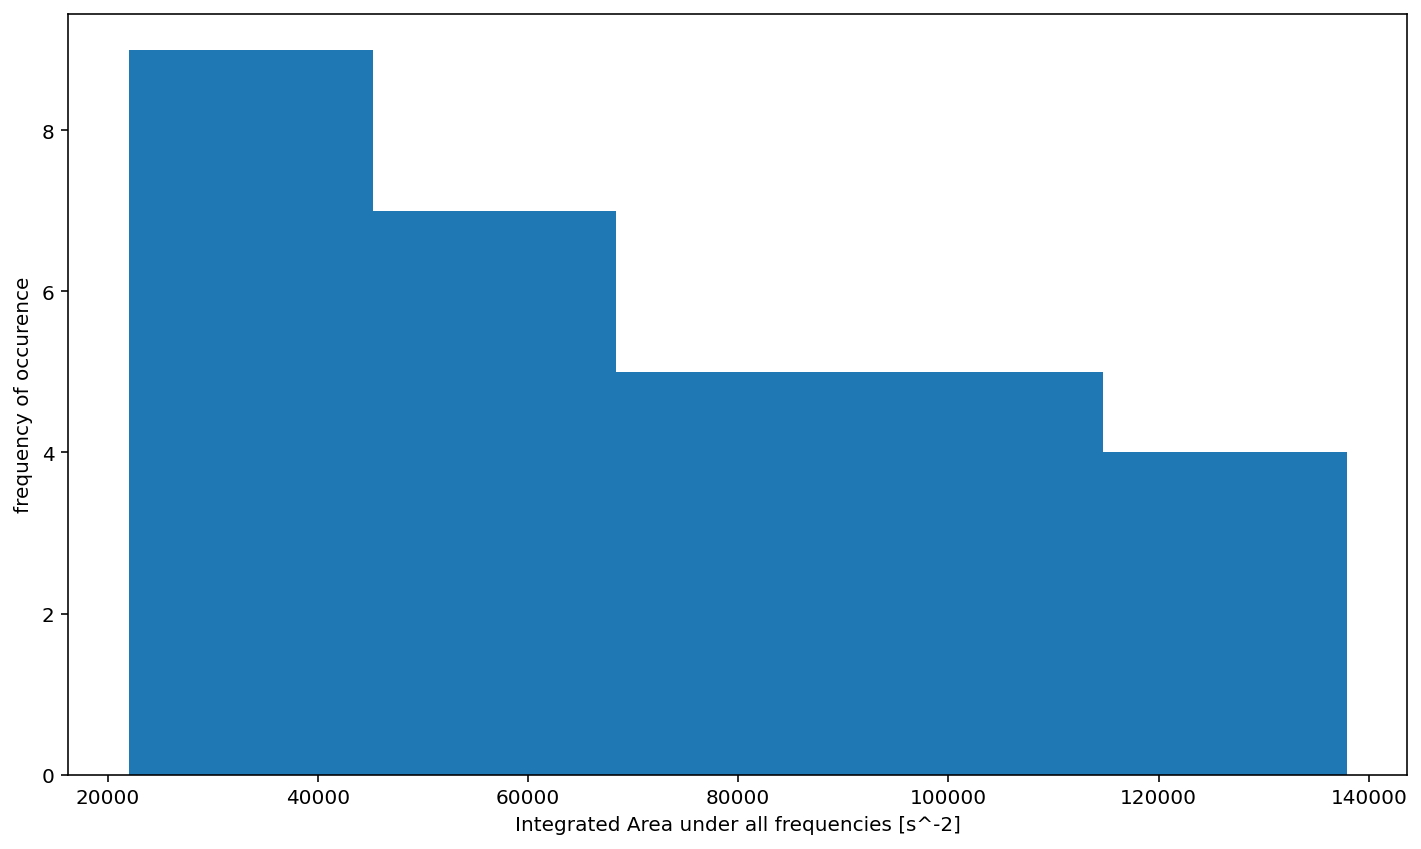

In [13]:
#generating histograms

#Note that code will take approximately 30 seconds to do 20 'runs' and 50 seconds for 30 runs

#Initializing the number of runs
num=30
tArr=np.zeros(num)
binArr=np.zeros(num)
tdArr=np.zeros(num)
maxfreqArray=np.zeros(num)
freqAreaArray=np.zeros(num)
for i in range(0,num):
    tArr[i],binArr[i],tdArr[i],maxfreqArray[i],freqAreaArray[i]=PlinkoHist(50,0.1,5.0)
    
#plotting histograms for all output values
    
plt.figure(1)
plt.hist(tArr,bins=5)
plt.xlabel("time [s]")
plt.ylabel("frequency of occurence")
           
plt.figure(2)
plt.hist(binArr,bins=10,range=(0,10))
plt.xlabel("Bin Number")
plt.ylabel("frequency of occurence")

plt.figure(3)
plt.hist(tdArr,bins=5)
plt.xlabel("Total displacement [m]")
plt.ylabel("frequency of occurence")

plt.figure(4)
plt.hist(maxfreqArray,bins=5)
plt.xlabel("Maximum Frequency [Hz]")
plt.ylabel("frequency of occurence")

plt.figure(5)
plt.hist(freqAreaArray,bins=5)
plt.xlabel("Integrated Area under all frequencies [s^-2]")
plt.ylabel("frequency of occurence")
           

# For a Total Drag Coefficient of 0.05

It takes  1.997 seconds for the disk to move through the plinko board.
The disk lands in bin 2.0
The total distance travelled by disk is 175.30274951349813 cm
The Area Under the Frequency Curve is 210229.8617088856 s^-2
Maximum Frequency Occurance is at 7 Hz


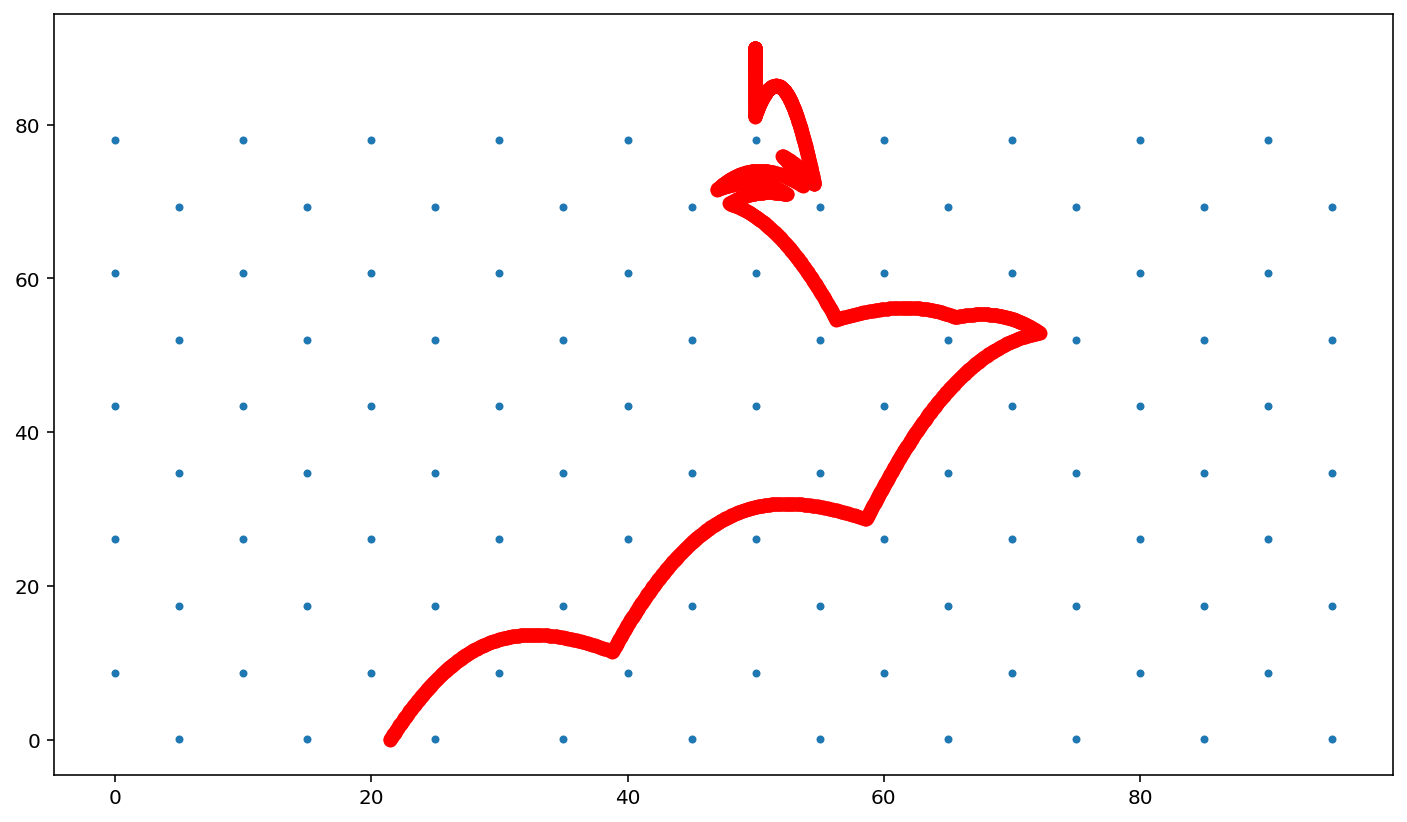

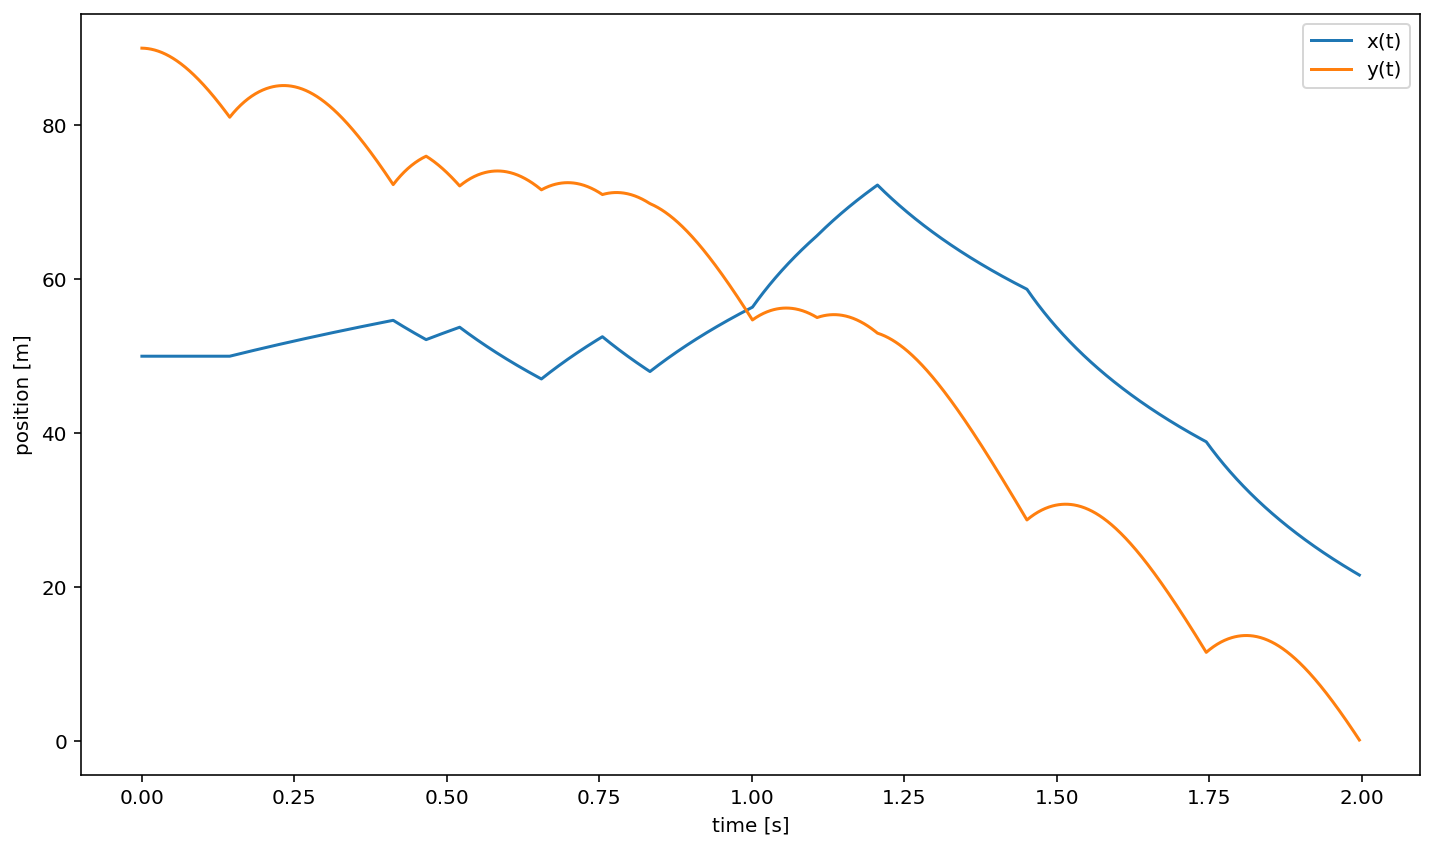

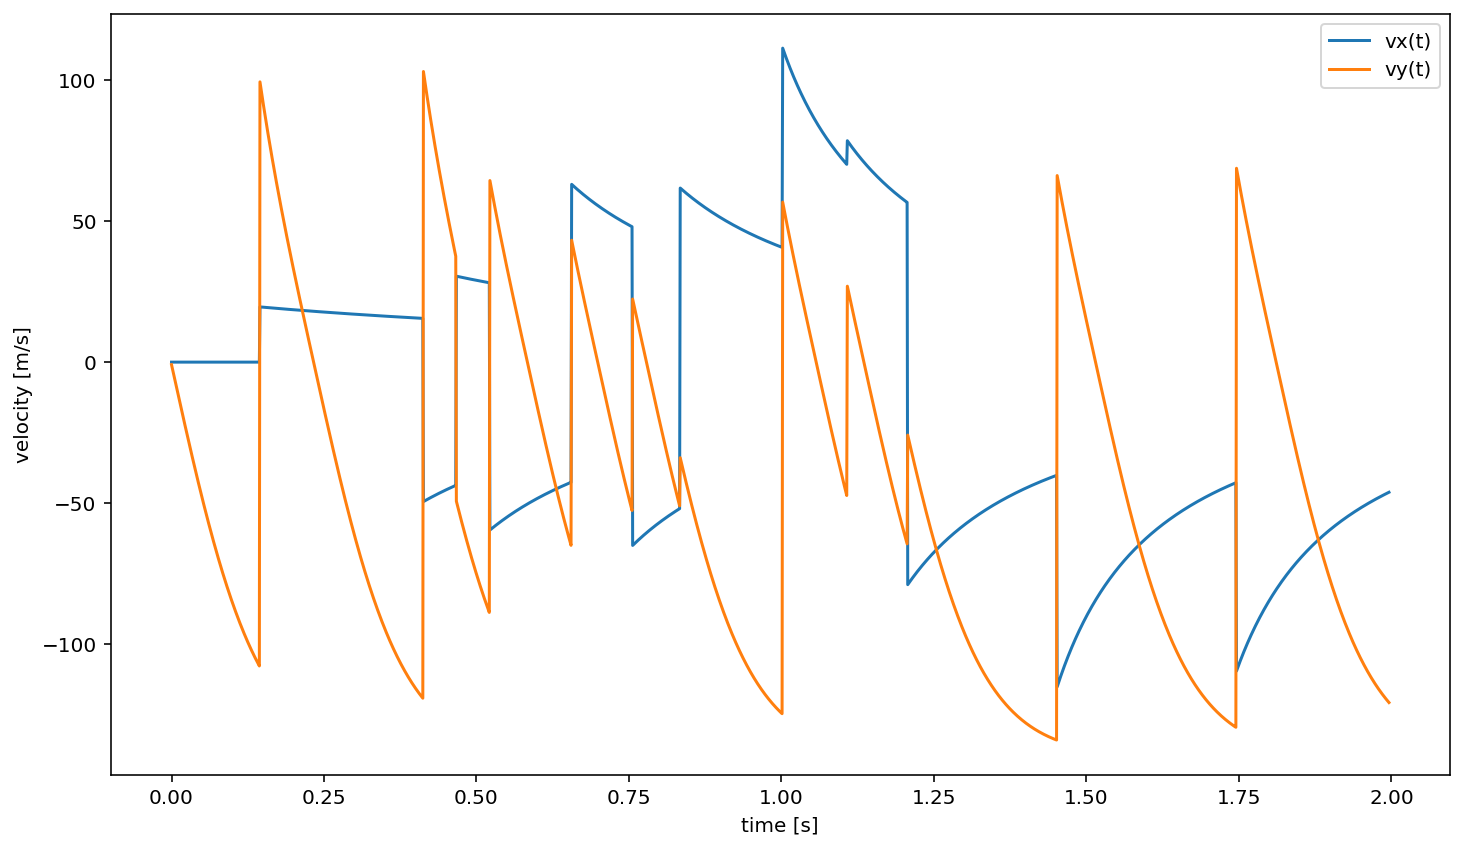

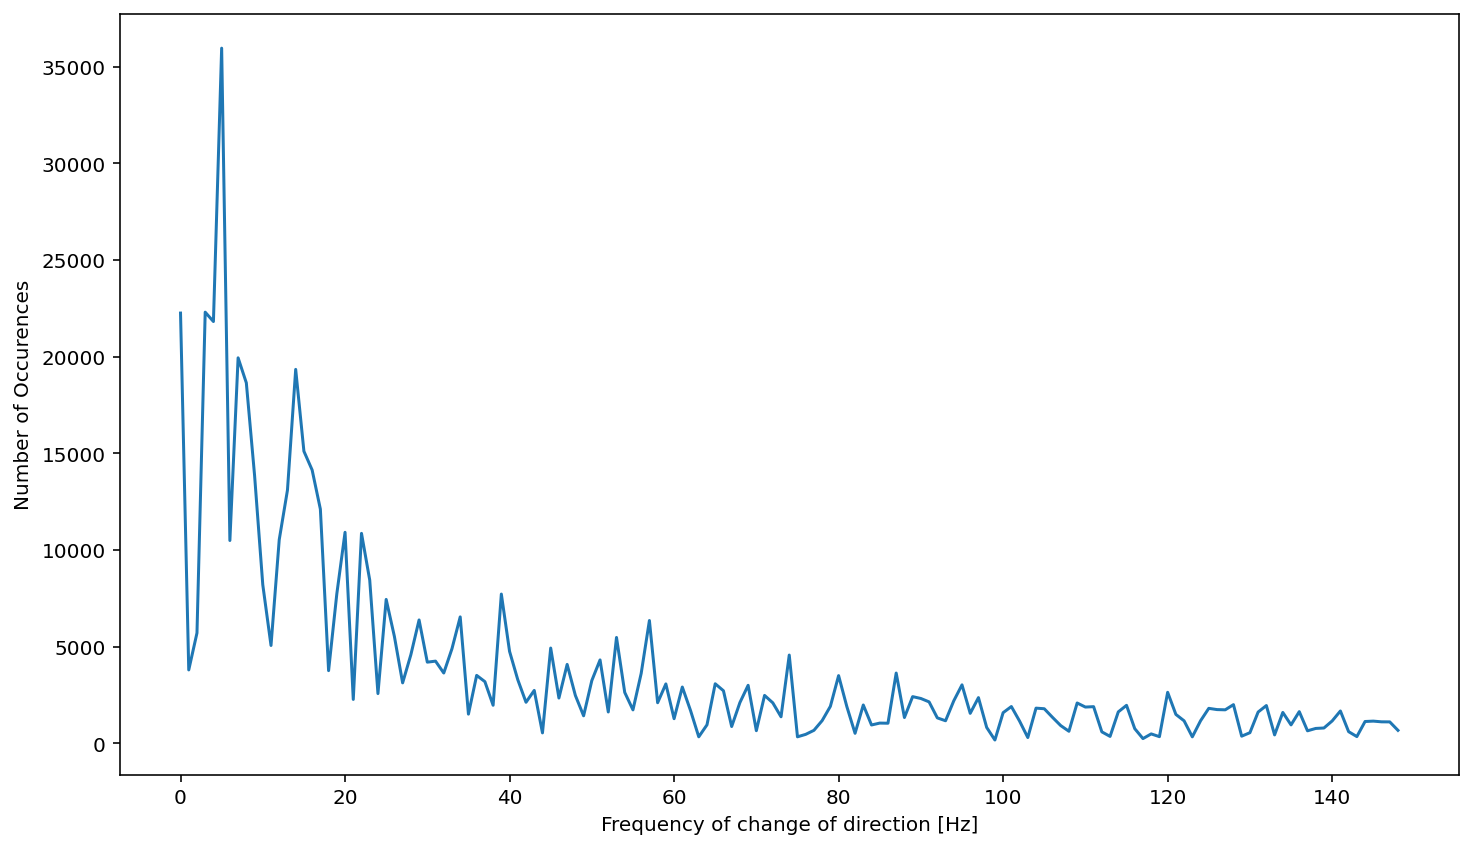

In [14]:
test,Bin,td,maxf,farea=Plinko(50,0.05,5.0)
print("It takes ",test, "seconds for the disk to move through the plinko board.")
print("The disk lands in bin",Bin)
print("The total distance travelled by disk is", td,"cm")
print("The Area Under the Frequency Curve is",farea,"s^-2" )
print("Maximum Frequency Occurance is at",maxf,"Hz")

Text(0, 0.5, 'frequency of occurence')

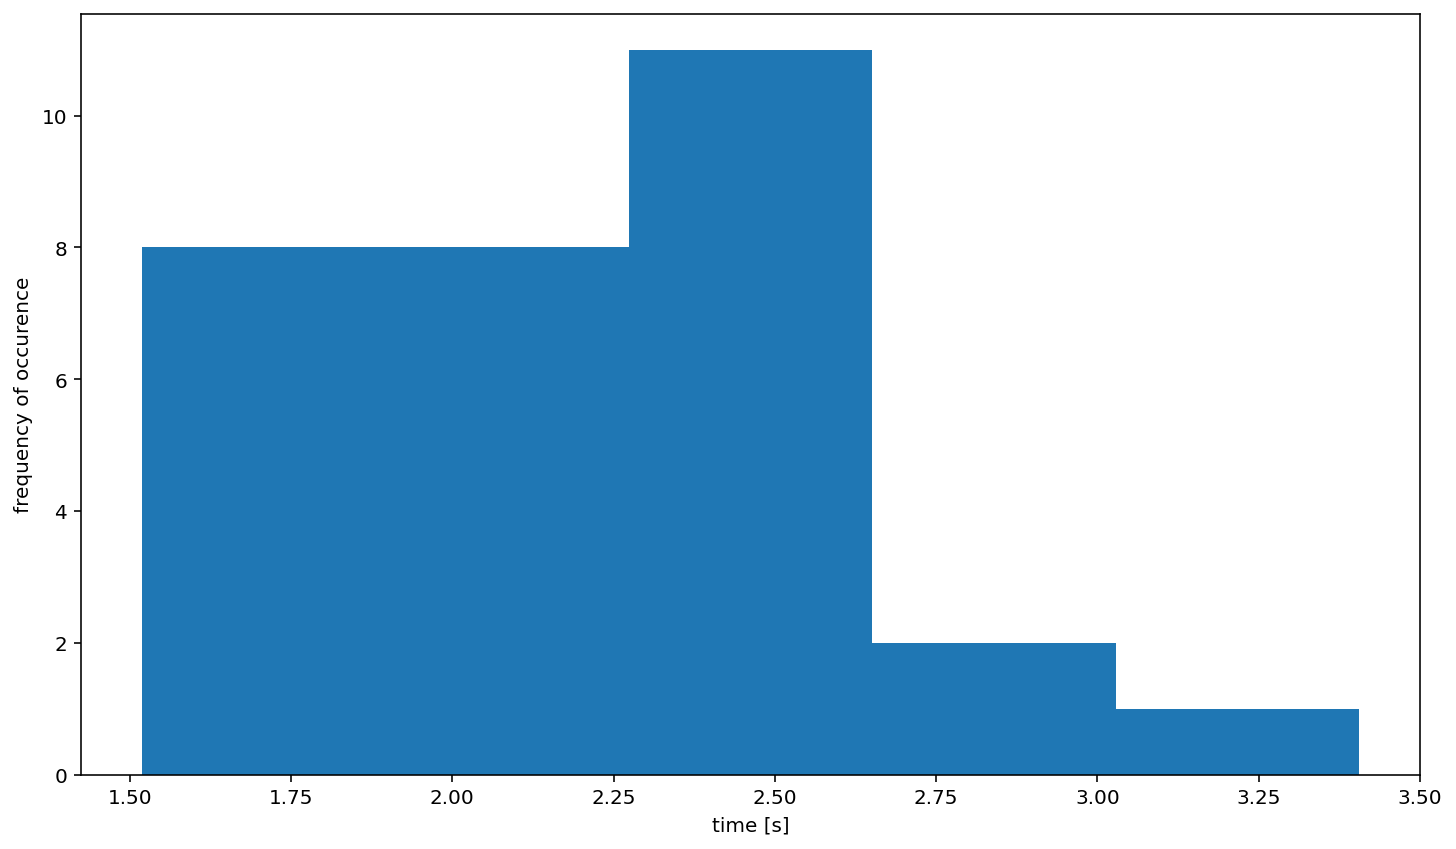

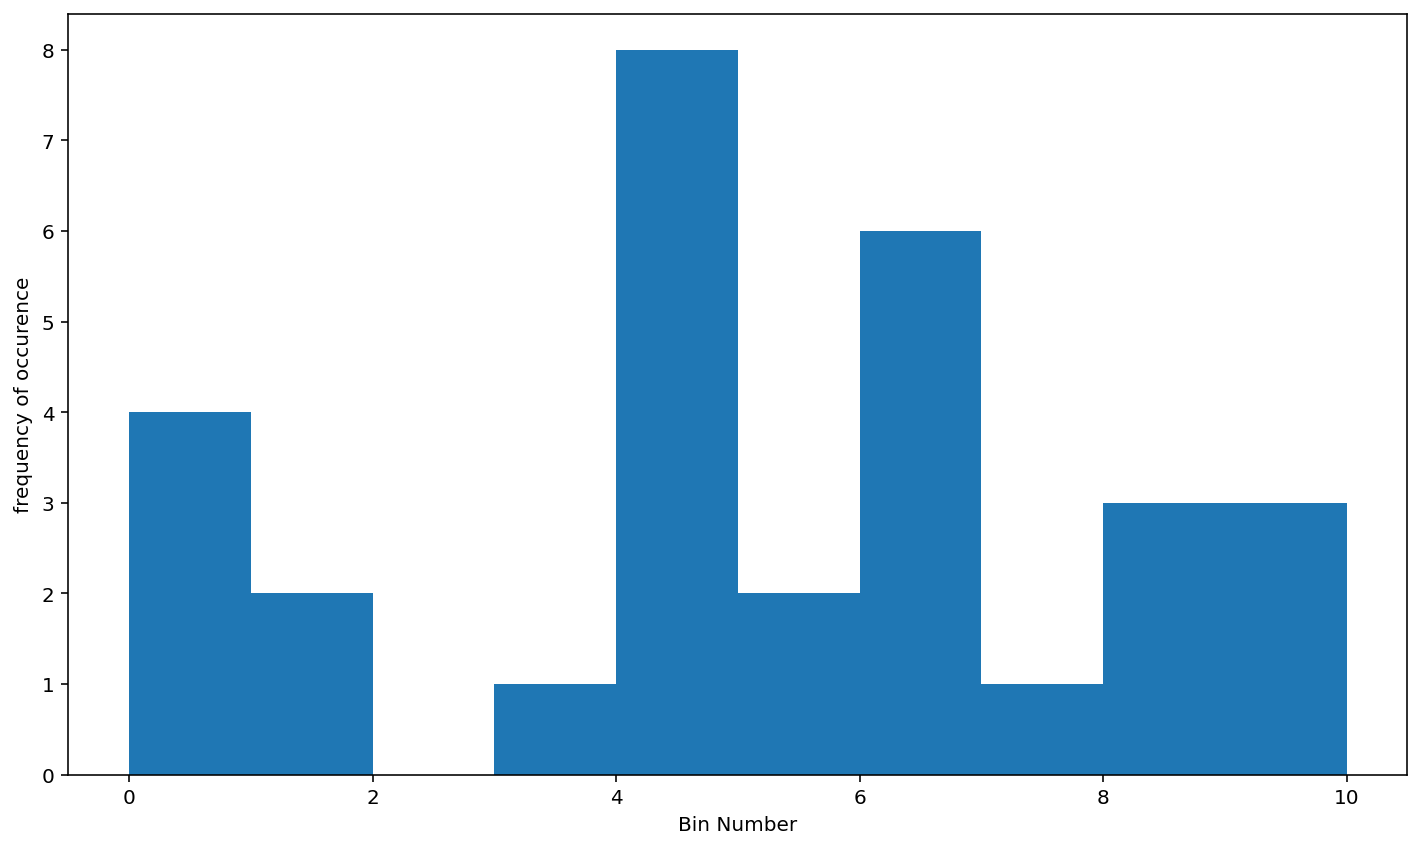

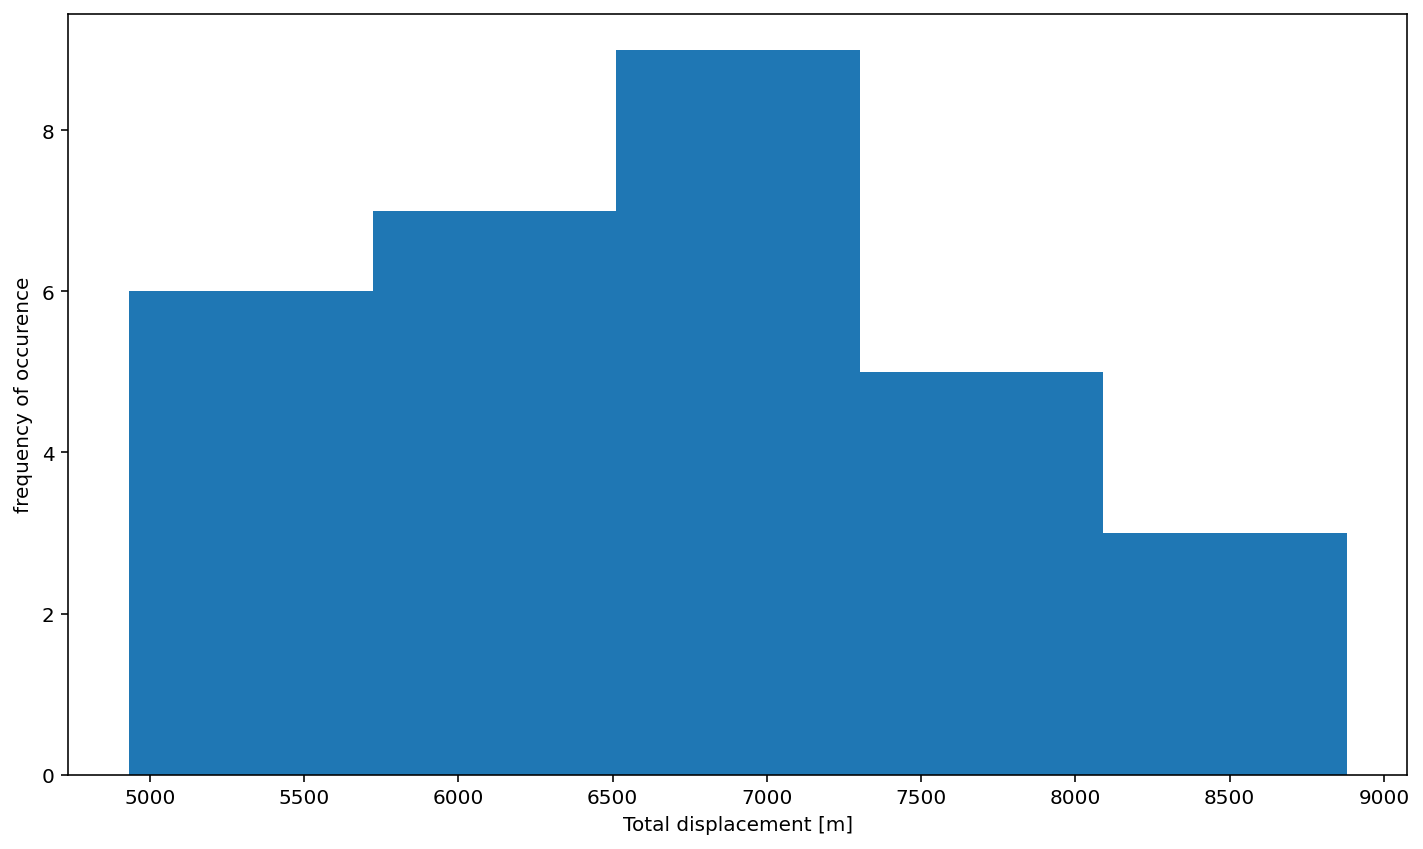

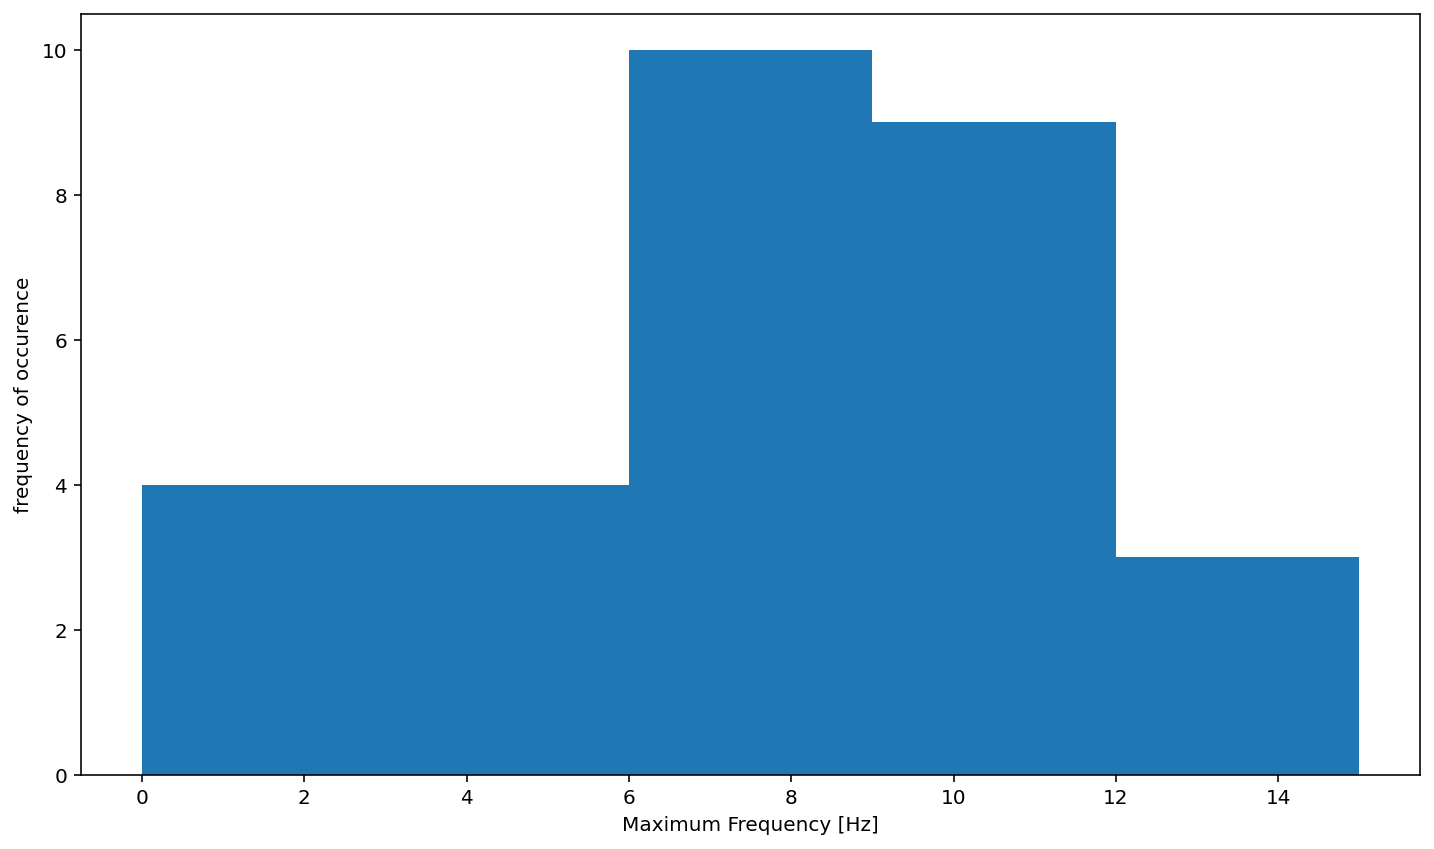

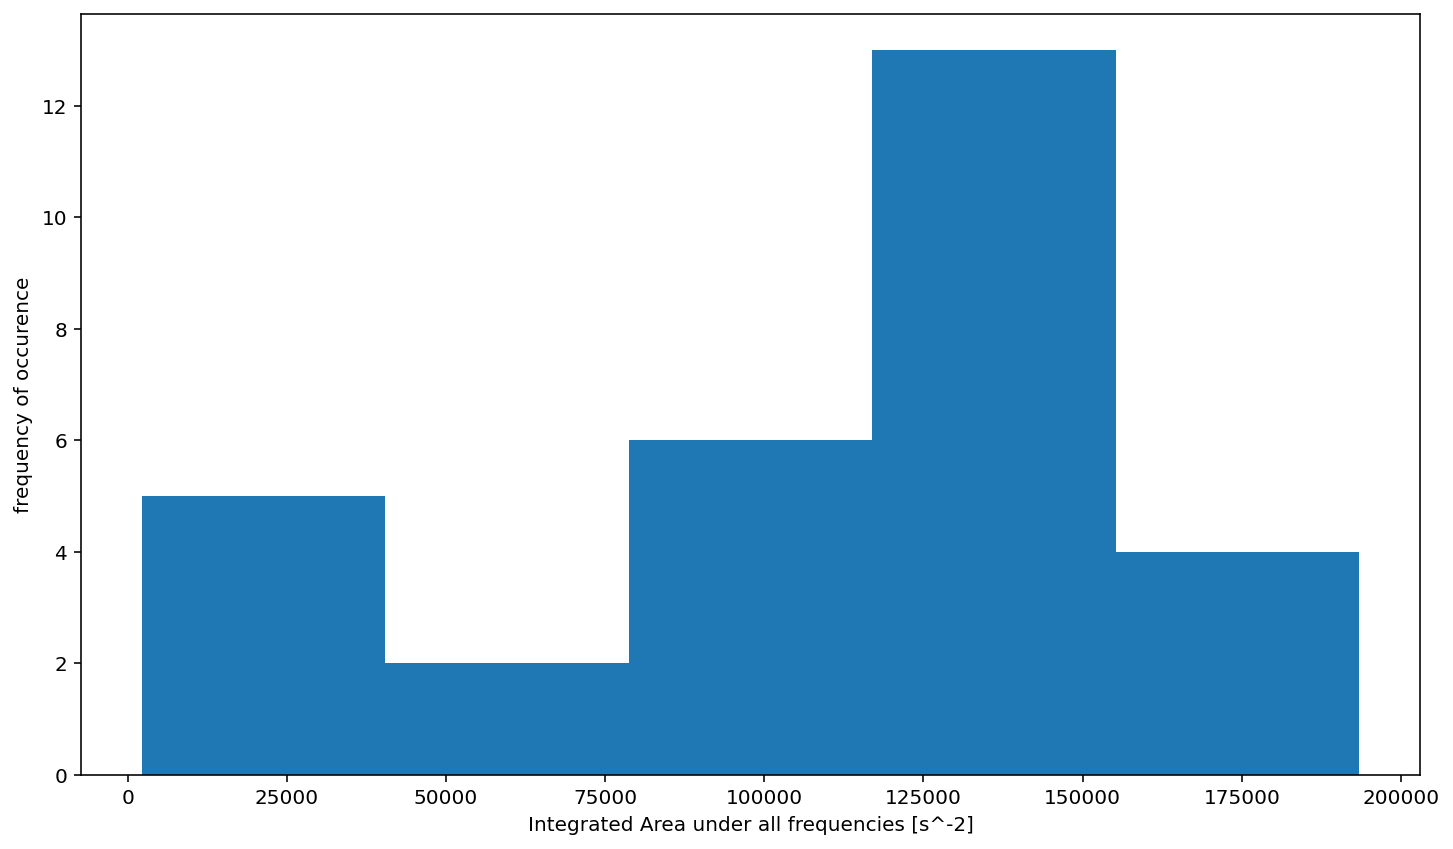

In [15]:
#generating histograms

#Note that code will take approximately 30 seconds to do 20 'runs' and 50 seconds for 30 runs

#Initializing the number of runs
num=30
tArr=np.zeros(num)
binArr=np.zeros(num)
tdArr=np.zeros(num)
maxfreqArray=np.zeros(num)
freqAreaArray=np.zeros(num)
for i in range(0,num):
    tArr[i],binArr[i],tdArr[i],maxfreqArray[i],freqAreaArray[i]=PlinkoHist(50,0.05,5.0)
    
#plotting histograms for all output values
    
plt.figure(1)
plt.hist(tArr,bins=5)
plt.xlabel("time [s]")
plt.ylabel("frequency of occurence")
           
plt.figure(2)
plt.hist(binArr,bins=10,range=(0,10))
plt.xlabel("Bin Number")
plt.ylabel("frequency of occurence")

plt.figure(3)
plt.hist(tdArr,bins=5)
plt.xlabel("Total displacement [m]")
plt.ylabel("frequency of occurence")

plt.figure(4)
plt.hist(maxfreqArray,bins=5)
plt.xlabel("Maximum Frequency [Hz]")
plt.ylabel("frequency of occurence")

plt.figure(5)
plt.hist(freqAreaArray,bins=5)
plt.xlabel("Integrated Area under all frequencies [s^-2]")
plt.ylabel("frequency of occurence")
           

# For a Total Drag Coefficient of 0.01


It takes  3.106 seconds for the disk to move through the plinko board.
The disk lands in bin 2.0
The total distance travelled by disk is 305.9541055132145 cm
The Area Under the Frequency Curve is 265278.0908554586 s^-2
Maximum Frequency Occurance is at 13 Hz


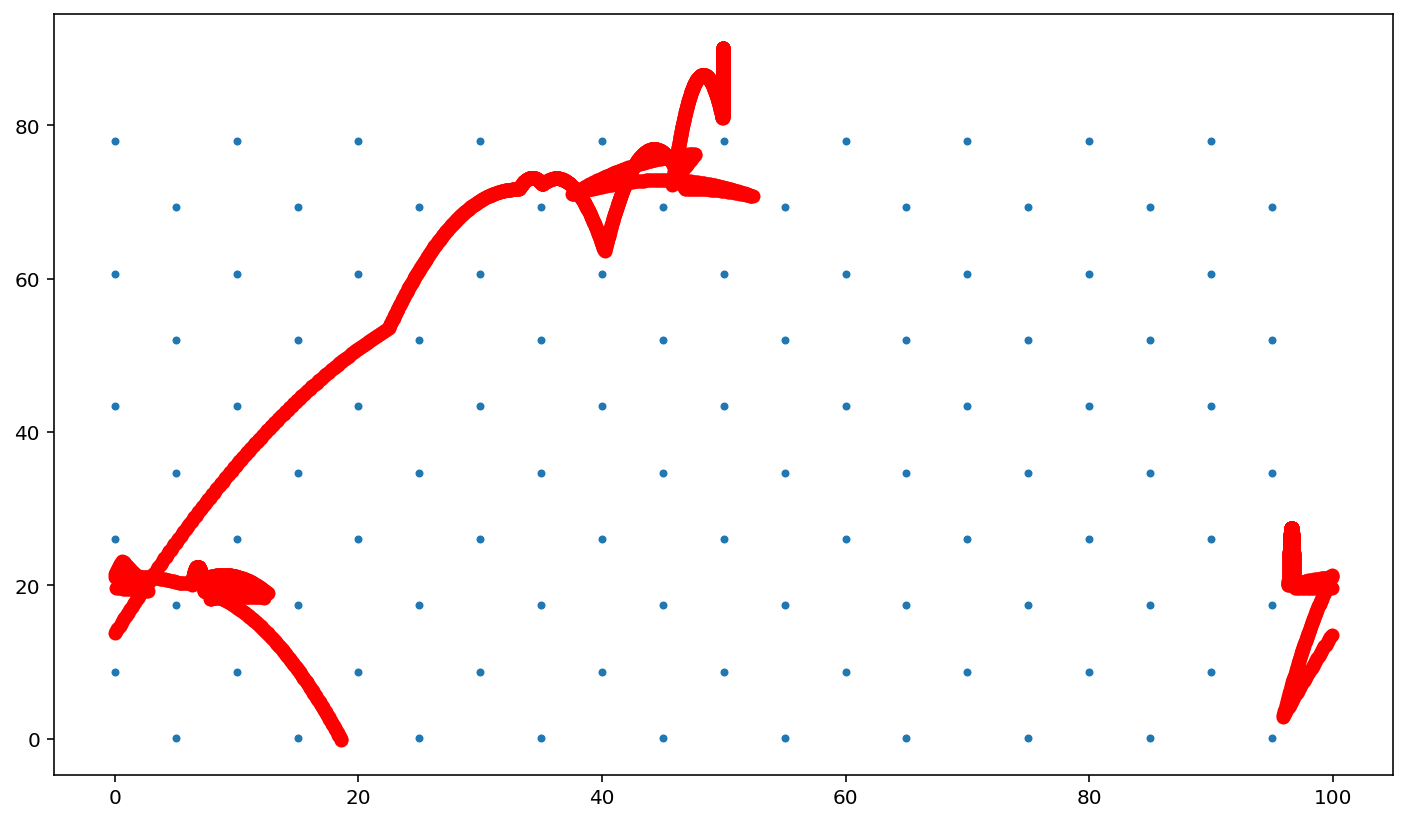

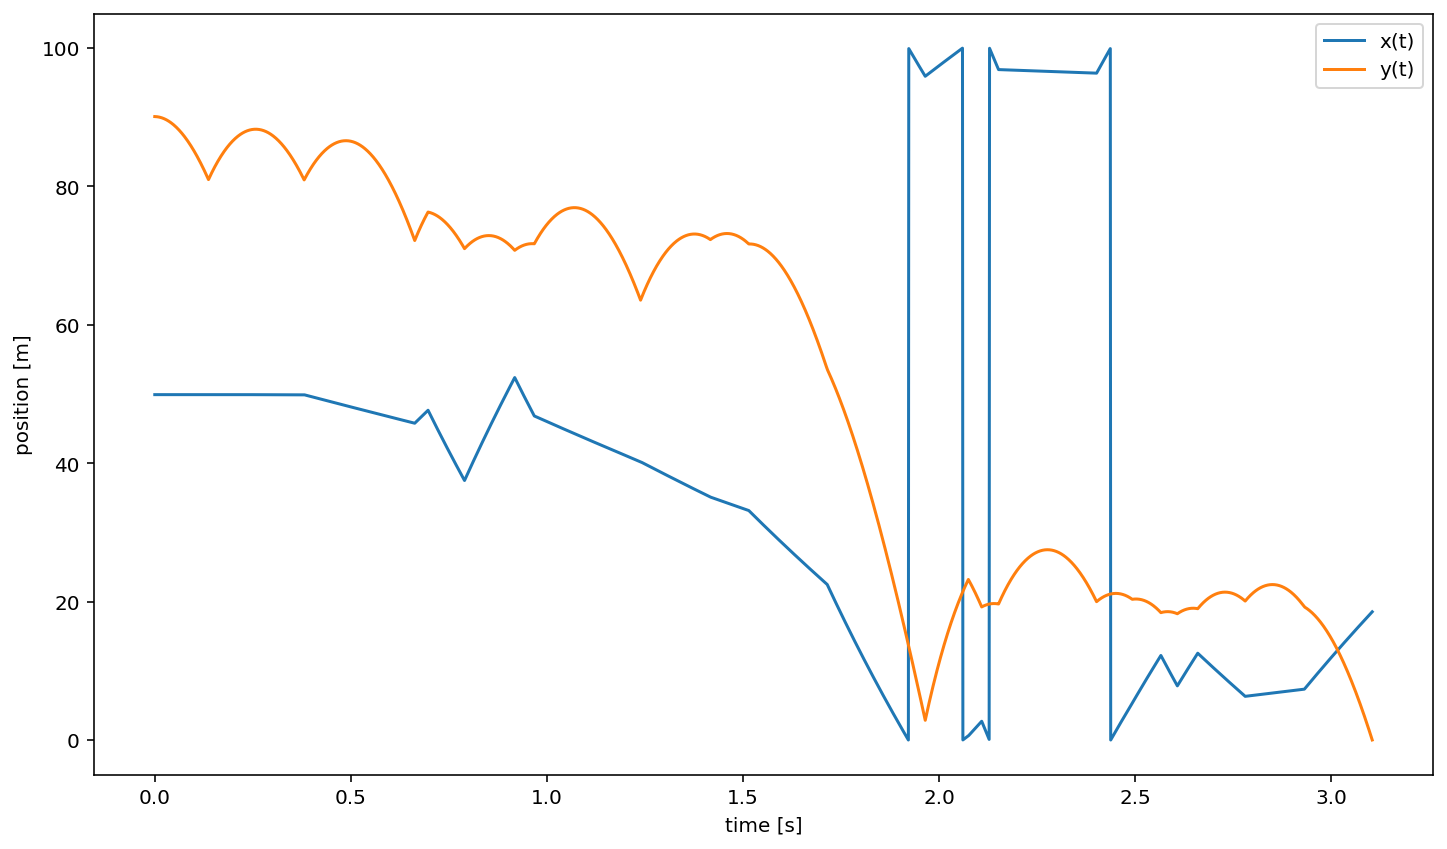

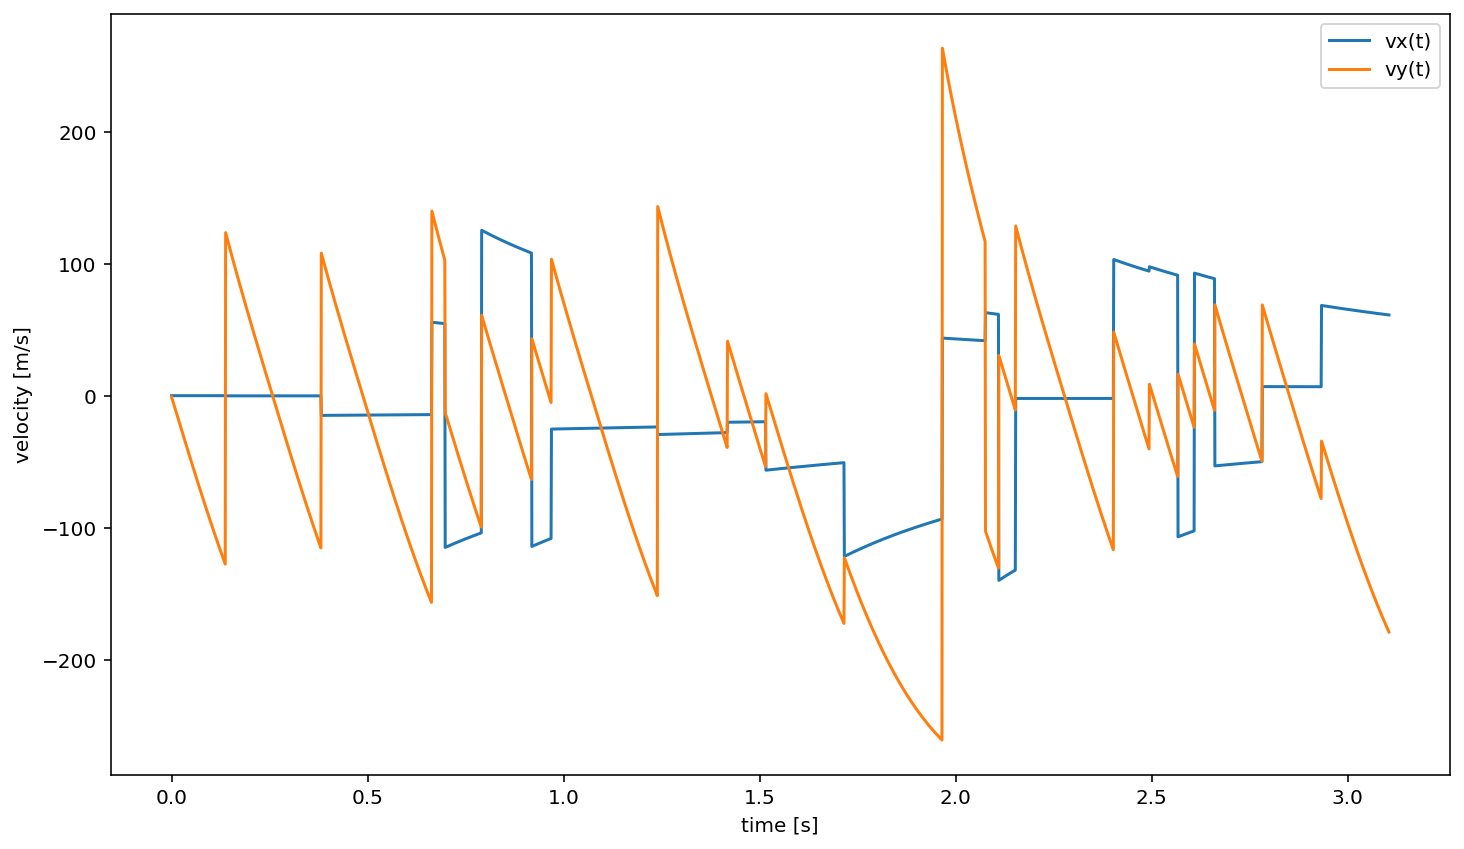

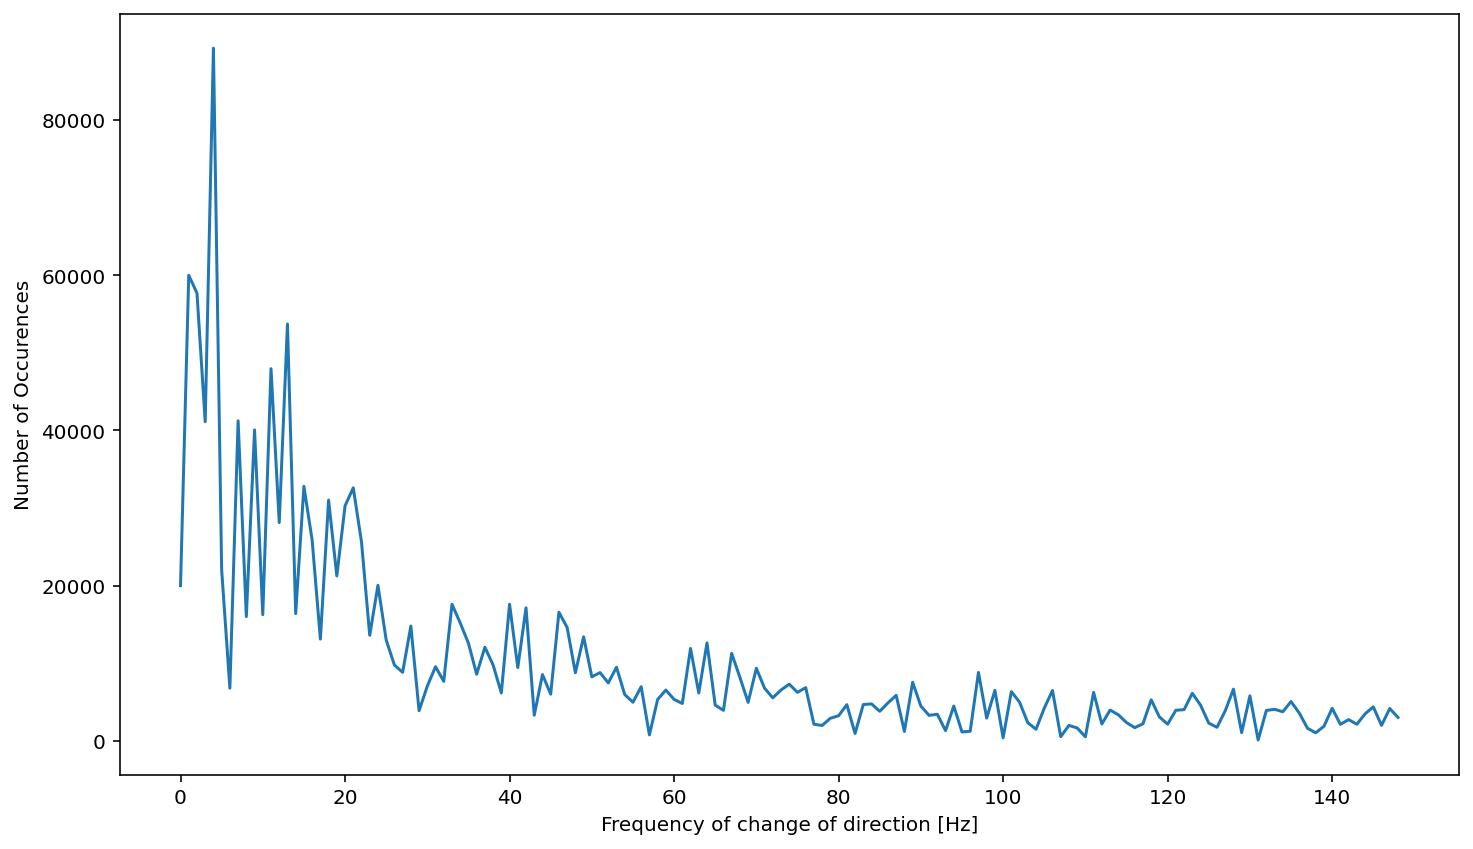

In [16]:
test,Bin,td,maxf,farea=Plinko(50,0.01,5.0)
print("It takes ",test, "seconds for the disk to move through the plinko board.")
print("The disk lands in bin",Bin)
print("The total distance travelled by disk is", td,"cm")
print("The Area Under the Frequency Curve is",farea,"s^-2" )
print("Maximum Frequency Occurance is at",maxf,"Hz")

Text(0, 0.5, 'frequency of occurence')

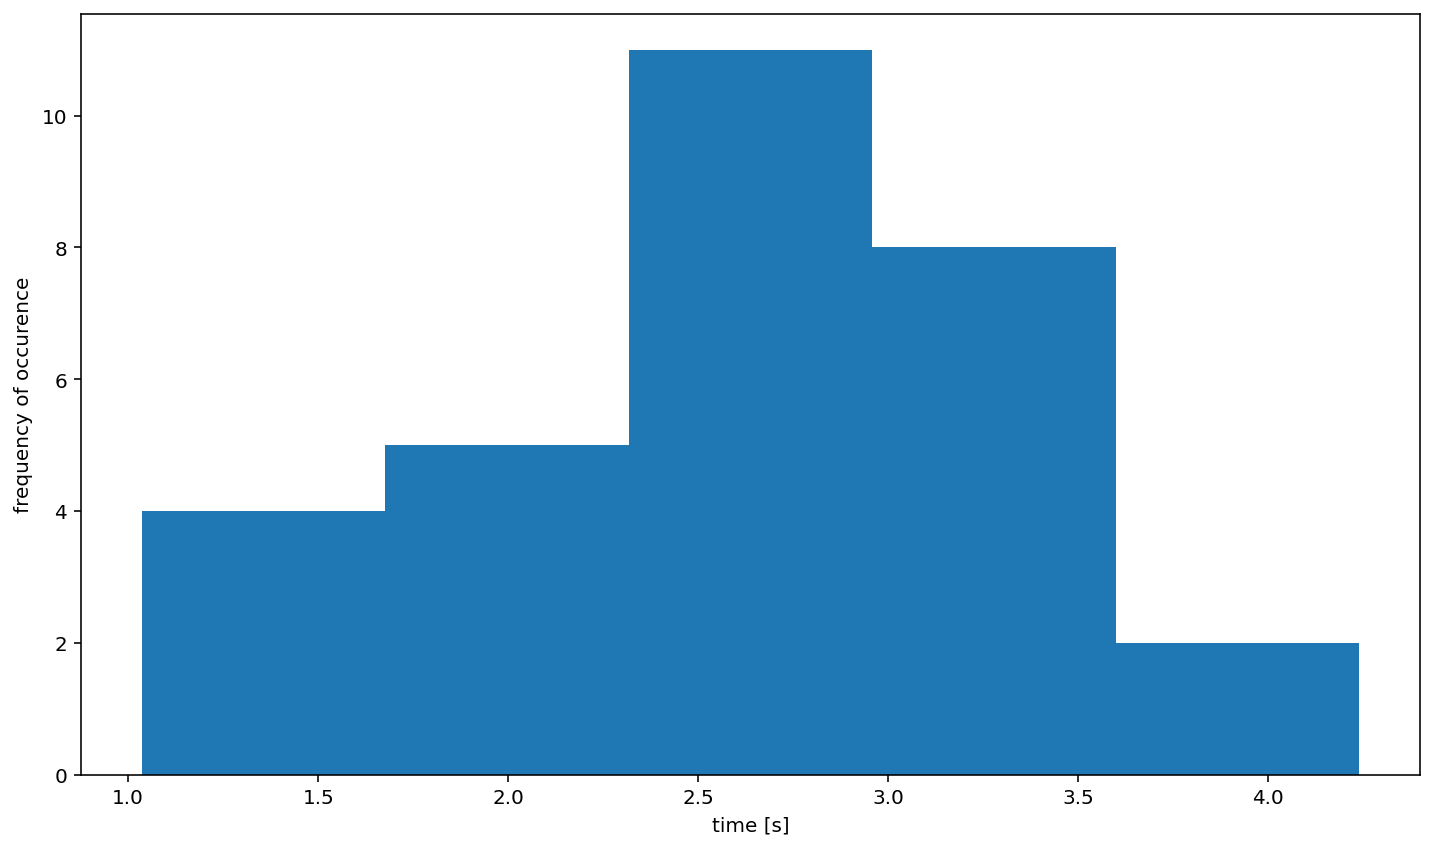

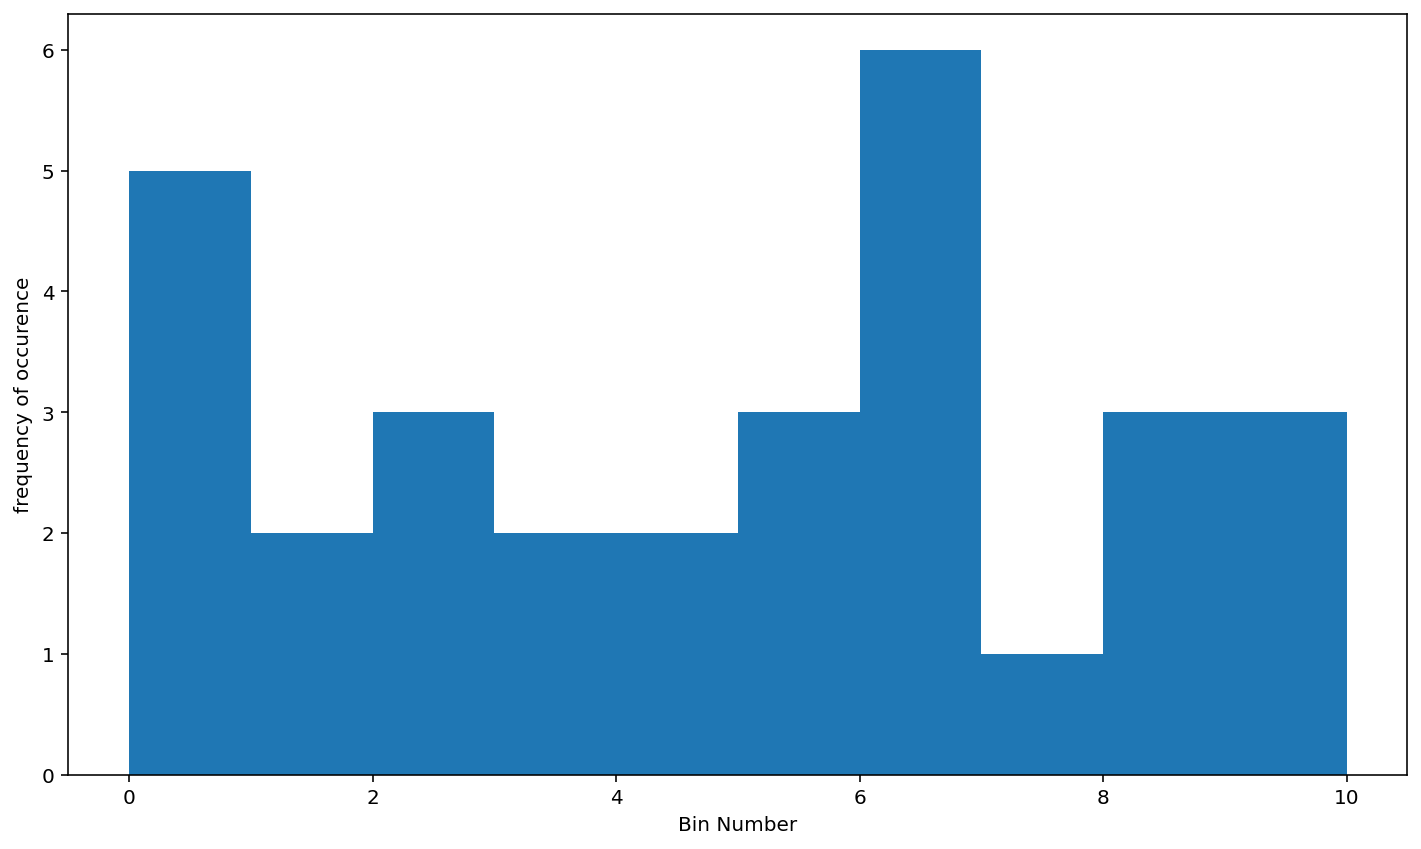

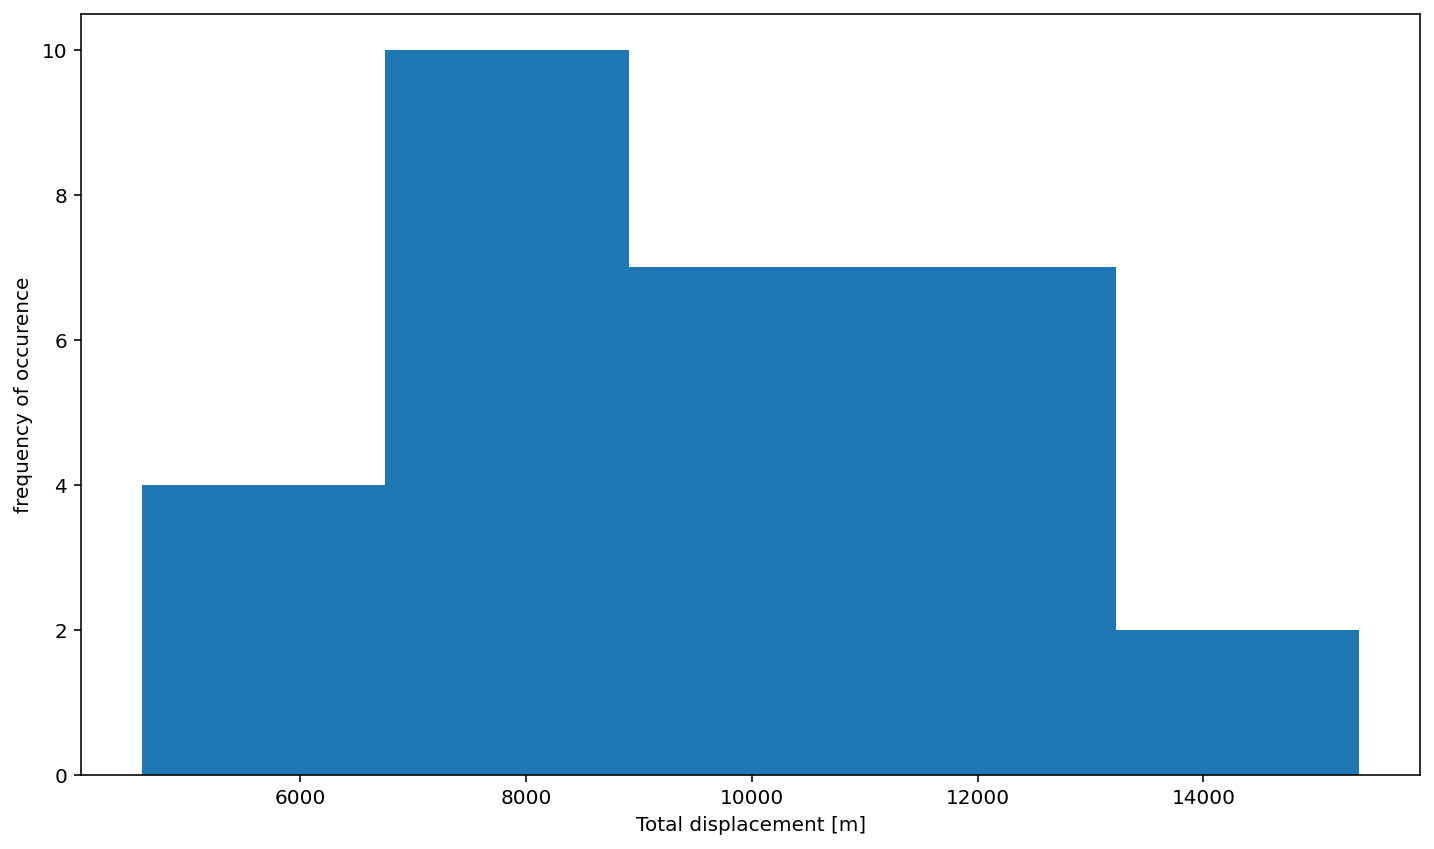

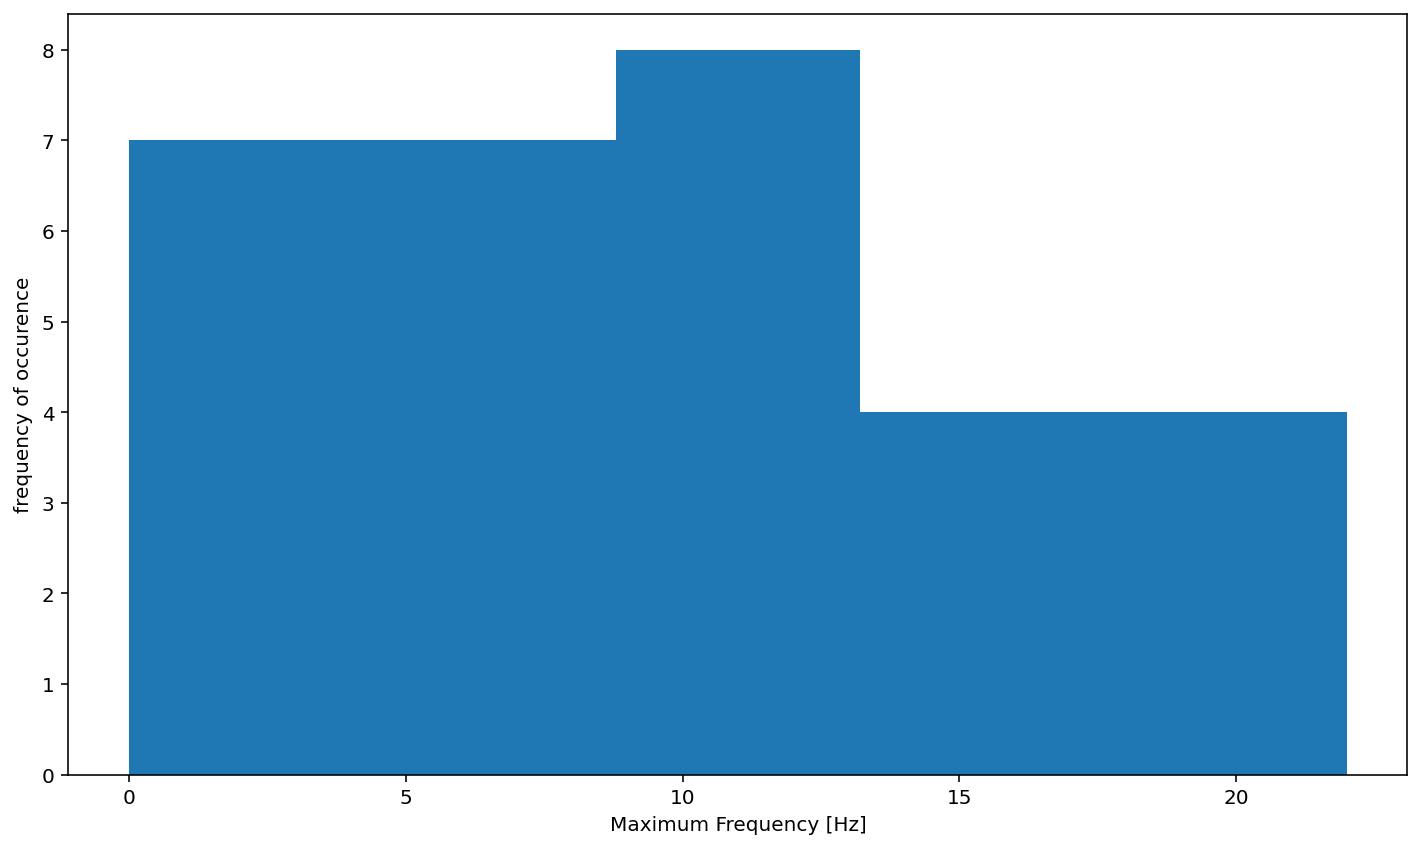

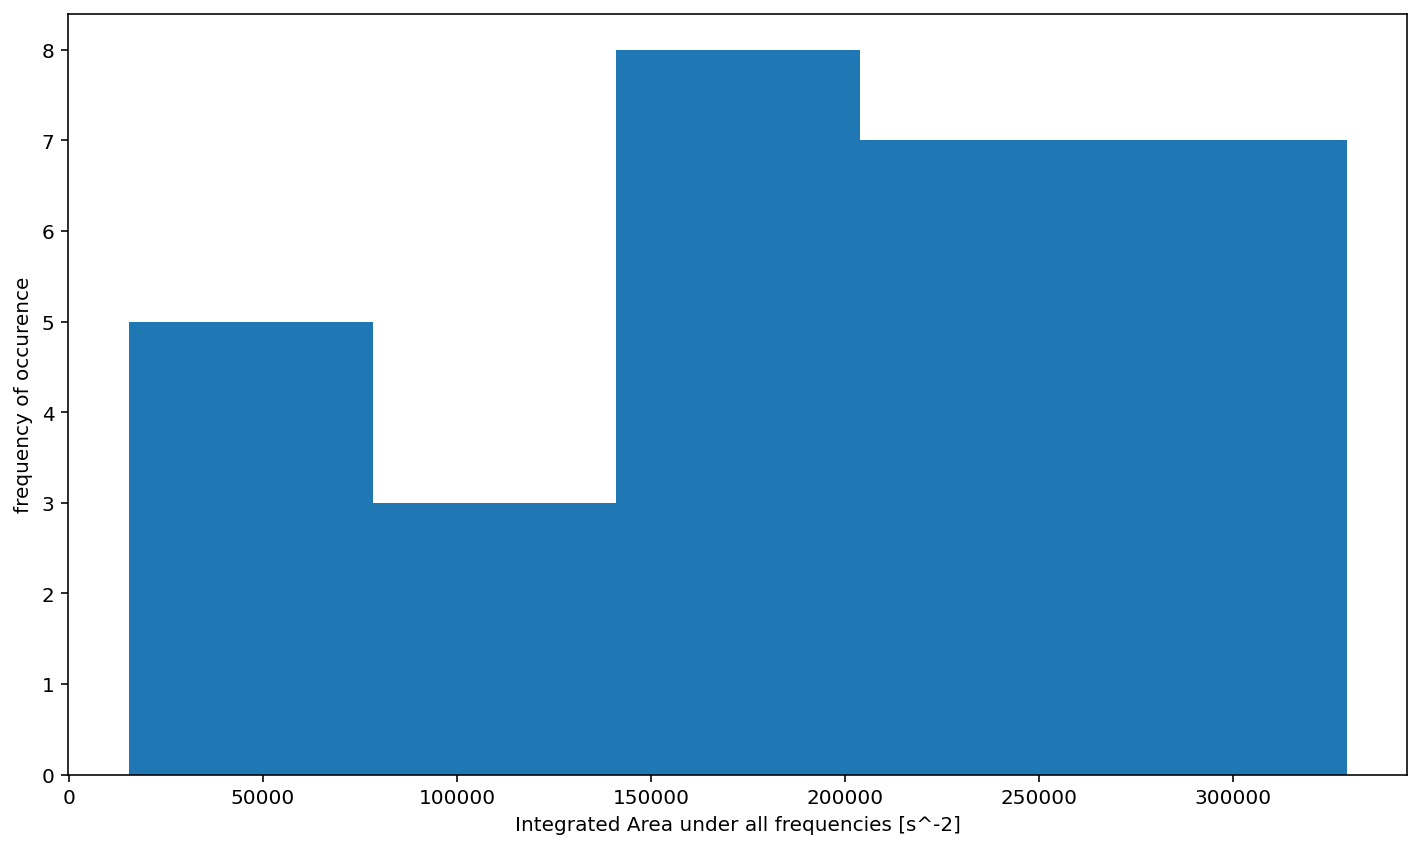

In [17]:
#generating histograms

#Note that code will take approximately 30 seconds to do 20 'runs' and 50 seconds for 30 runs

#Initializing the number of runs
num=30
tArr=np.zeros(num)
binArr=np.zeros(num)
tdArr=np.zeros(num)
maxfreqArray=np.zeros(num)
freqAreaArray=np.zeros(num)
for i in range(0,num):
    tArr[i],binArr[i],tdArr[i],maxfreqArray[i],freqAreaArray[i]=PlinkoHist(50,0.01,5.0)
    
#plotting histograms for all output values
    
plt.figure(1)
plt.hist(tArr,bins=5)
plt.xlabel("time [s]")
plt.ylabel("frequency of occurence")
           
plt.figure(2)
plt.hist(binArr,bins=10,range=(0,10))
plt.xlabel("Bin Number")
plt.ylabel("frequency of occurence")

plt.figure(3)
plt.hist(tdArr,bins=5)
plt.xlabel("Total displacement [m]")
plt.ylabel("frequency of occurence")

plt.figure(4)
plt.hist(maxfreqArray,bins=5)
plt.xlabel("Maximum Frequency [Hz]")
plt.ylabel("frequency of occurence")

plt.figure(5)
plt.hist(freqAreaArray,bins=5)
plt.xlabel("Integrated Area under all frequencies [s^-2]")
plt.ylabel("frequency of occurence")